# I. Urbansound 8K (https://urbansounddataset.weebly.com/urbansound8k.html)
## - Data are saved in 10-fold but needs to be extracted into one folder for the data processing in this notebook
## - Generated Data are saved in binary files (Due to size limit, not update in Github, but it can be generated by this notebook) 
### - api_rnn_tensor_nosplit: one dataset contains all sound data for RNN training without any split ((x_train, y_train) = api_rnn_tenor_nosplit)
### - api_cnn_tensor_nosplit: one dataset contains all sound data for CNN training without any split ((x_train, y_train) = api_cnn_tenor_nosplit)
### - api_rnn_tensor: one dataset contains all sound data for RNN training with a split 80% for train and 20% for validation ((x_train, y_train, x_val, y_val) = api_rnn_tenor)
### - api_cnn_tensor: one dataset contains all sound data for RNN training with a split 80% for train and 20% for validation ((x_train, y_train, x_val, y_val) = api_cnn_tenor)

# II. Data Processing Content
## - Parse audio data into 1-dim vector
## - Merge parsed audio data into dataframe
## - Reproduce car_horn sound samples by RNN
## - Reproduce gun_shot sound samples by RNN
## - Balance dataset for each label
## - Generate Mel-Spectrogram data from parsed audio data with the consistent matrix shape
## - Generate tensor of sound images created by Mel-Spectrogram matrices
## - Generate dataset for CNN, RNN wihout a split
## - Generate dataset for CNN, RNN train & validation

# Parse Audio Data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from keras import Model
from keras.layers import LSTM, Dense, Flatten, Input
from keras.models import load_model
from keras.preprocessing import image
import os
import IPython.display as ipd
import librosa as lirs
import librosa.display as lirs_plt
import numpy as np
import pandas as pd
from copy import deepcopy
import pickle
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [21]:
data = pd.read_csv('./UrbanSound8K.csv')

In [22]:
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [23]:
# drop useless columns: fsID, start, end, salience, fold
data = data.drop(['fsID','start','end','salience','fold'],axis=1)
data.head()

slice_file_name  classID             class
0    100032-3-0-0.wav        3          dog_bark
1  100263-2-0-117.wav        2  children_playing
2  100263-2-0-121.wav        2  children_playing
3  100263-2-0-126.wav        2  children_playing
4  100263-2-0-137.wav        2  children_playing

In [34]:
'''
- Parse the audio data into dataframe by librosa
'''
def parse_audio_file(file_id):
    print(f'slice_file_name: {file_id}')
    sample_data, sample_rate = lirs.load(f'./DataFolder/{file_id}', dtype = np.float32,)
    sample_time = len(sample_data)/sample_rate
    return [sample_time, sample_rate, sample_data]

audio_info = list(map(parse_audio_file, data['slice_file_name']))

slice_file_name: 100032-3-0-0.wav
slice_file_name: 100263-2-0-117.wav
slice_file_name: 100263-2-0-121.wav
slice_file_name: 100263-2-0-126.wav
slice_file_name: 100263-2-0-137.wav
slice_file_name: 100263-2-0-143.wav
slice_file_name: 100263-2-0-161.wav
slice_file_name: 100263-2-0-3.wav
slice_file_name: 100263-2-0-36.wav
slice_file_name: 100648-1-0-0.wav
slice_file_name: 100648-1-1-0.wav
slice_file_name: 100648-1-2-0.wav
slice_file_name: 100648-1-3-0.wav
slice_file_name: 100648-1-4-0.wav
slice_file_name: 100652-3-0-0.wav
slice_file_name: 100652-3-0-1.wav
slice_file_name: 100652-3-0-2.wav
slice_file_name: 100652-3-0-3.wav
slice_file_name: 100795-3-0-0.wav
slice_file_name: 100795-3-1-0.wav
slice_file_name: 100795-3-1-1.wav
slice_file_name: 100795-3-1-2.wav
slice_file_name: 100852-0-0-0.wav
slice_file_name: 100852-0-0-1.wav
slice_file_name: 100852-0-0-10.wav
slice_file_name: 100852-0-0-11.wav
slice_file_name: 100852-0-0-12.wav
slice_file_name: 100852-0-0-13.wav
slice_file_name: 100852-0-0-14.

slice_file_name: 103258-5-0-1.wav
slice_file_name: 103258-5-0-10.wav
slice_file_name: 103258-5-0-11.wav
slice_file_name: 103258-5-0-12.wav
slice_file_name: 103258-5-0-13.wav
slice_file_name: 103258-5-0-14.wav
slice_file_name: 103258-5-0-15.wav
slice_file_name: 103258-5-0-16.wav
slice_file_name: 103258-5-0-17.wav
slice_file_name: 103258-5-0-18.wav
slice_file_name: 103258-5-0-19.wav
slice_file_name: 103258-5-0-2.wav
slice_file_name: 103258-5-0-3.wav
slice_file_name: 103258-5-0-4.wav
slice_file_name: 103258-5-0-5.wav
slice_file_name: 103258-5-0-6.wav
slice_file_name: 103258-5-0-7.wav
slice_file_name: 103258-5-0-8.wav
slice_file_name: 103258-5-0-9.wav
slice_file_name: 103357-4-0-0.wav
slice_file_name: 103357-4-0-1.wav
slice_file_name: 103438-5-0-0.wav
slice_file_name: 103438-5-0-1.wav
slice_file_name: 103438-5-0-2.wav
slice_file_name: 104327-2-0-15.wav
slice_file_name: 104327-2-0-19.wav
slice_file_name: 104327-2-0-26.wav
slice_file_name: 104327-2-0-28.wav
slice_file_name: 104327-2-0-3.wav


slice_file_name: 106015-5-0-3.wav
slice_file_name: 106015-5-0-4.wav
slice_file_name: 106015-5-0-5.wav
slice_file_name: 106015-5-0-6.wav
slice_file_name: 106015-5-0-7.wav
slice_file_name: 106015-5-0-8.wav
slice_file_name: 106015-5-0-9.wav
slice_file_name: 106486-5-0-0.wav
slice_file_name: 106486-5-0-1.wav
slice_file_name: 106486-5-0-2.wav
slice_file_name: 106487-5-0-0.wav
slice_file_name: 106487-5-0-1.wav
slice_file_name: 106487-5-0-2.wav
slice_file_name: 106905-5-0-0.wav
slice_file_name: 106905-5-0-1.wav
slice_file_name: 106905-5-0-2.wav
slice_file_name: 106905-8-0-0.wav
slice_file_name: 106905-8-0-1.wav
slice_file_name: 106905-8-0-2.wav
slice_file_name: 106905-8-0-3.wav
slice_file_name: 106955-6-0-0.wav
slice_file_name: 107090-1-0-0.wav
slice_file_name: 107090-1-1-0.wav
slice_file_name: 107190-3-0-0.wav
slice_file_name: 107228-5-0-0.wav
slice_file_name: 107228-5-0-1.wav
slice_file_name: 107228-5-0-2.wav
slice_file_name: 107228-5-0-3.wav
slice_file_name: 107228-5-0-4.wav
slice_file_nam

slice_file_name: 113202-5-0-7.wav
slice_file_name: 113202-5-0-8.wav
slice_file_name: 113202-5-0-9.wav
slice_file_name: 113203-5-0-0.wav
slice_file_name: 113203-5-0-1.wav
slice_file_name: 113203-5-0-2.wav
slice_file_name: 113203-5-0-3.wav
slice_file_name: 113203-5-0-4.wav
slice_file_name: 113203-5-0-5.wav
slice_file_name: 113203-5-0-6.wav
slice_file_name: 113203-5-0-7.wav
slice_file_name: 113203-5-0-8.wav
slice_file_name: 113203-5-1-0.wav
slice_file_name: 113203-5-1-1.wav
slice_file_name: 113203-5-1-2.wav
slice_file_name: 113203-5-2-0.wav
slice_file_name: 113203-5-3-0.wav
slice_file_name: 113203-5-3-1.wav
slice_file_name: 113203-5-4-0.wav
slice_file_name: 113203-5-5-0.wav
slice_file_name: 113203-5-6-0.wav
slice_file_name: 113203-5-7-0.wav
slice_file_name: 113203-5-8-0.wav
slice_file_name: 113205-5-0-0.wav
slice_file_name: 113205-5-1-0.wav
slice_file_name: 113205-5-1-1.wav
slice_file_name: 113205-5-1-2.wav
slice_file_name: 113205-5-1-3.wav
slice_file_name: 113205-5-1-4.wav
slice_file_nam

slice_file_name: 119455-5-0-5.wav
slice_file_name: 119455-5-0-6.wav
slice_file_name: 119455-5-0-7.wav
slice_file_name: 119809-7-0-0.wav
slice_file_name: 119809-7-0-1.wav
slice_file_name: 119809-7-0-2.wav
slice_file_name: 119809-7-0-3.wav
slice_file_name: 119809-7-0-4.wav
slice_file_name: 119809-7-0-5.wav
slice_file_name: 119809-7-0-6.wav
slice_file_name: 121285-0-0-0.wav
slice_file_name: 121285-0-0-1.wav
slice_file_name: 121285-0-0-2.wav
slice_file_name: 121285-0-0-3.wav
slice_file_name: 121285-0-0-4.wav
slice_file_name: 121285-0-0-5.wav
slice_file_name: 121285-0-0-6.wav
slice_file_name: 121285-0-0-7.wav
slice_file_name: 121285-0-0-8.wav
slice_file_name: 121285-0-0-9.wav
slice_file_name: 121286-0-0-0.wav
slice_file_name: 121286-0-0-1.wav
slice_file_name: 121286-0-0-10.wav
slice_file_name: 121286-0-0-11.wav
slice_file_name: 121286-0-0-12.wav
slice_file_name: 121286-0-0-13.wav
slice_file_name: 121286-0-0-14.wav
slice_file_name: 121286-0-0-15.wav
slice_file_name: 121286-0-0-2.wav
slice_fi

slice_file_name: 128160-5-0-8.wav
slice_file_name: 128160-5-0-9.wav
slice_file_name: 128240-3-0-1.wav
slice_file_name: 128240-3-0-20.wav
slice_file_name: 128240-3-0-39.wav
slice_file_name: 128240-3-0-42.wav
slice_file_name: 128465-1-0-0.wav
slice_file_name: 128465-1-0-1.wav
slice_file_name: 128465-1-0-2.wav
slice_file_name: 128465-1-0-3.wav
slice_file_name: 128465-1-0-4.wav
slice_file_name: 128465-1-0-5.wav
slice_file_name: 128465-1-0-6.wav
slice_file_name: 128465-1-0-7.wav
slice_file_name: 128465-1-0-8.wav
slice_file_name: 128470-3-0-0.wav
slice_file_name: 128470-3-0-1.wav
slice_file_name: 128470-3-0-5.wav
slice_file_name: 128470-3-0-8.wav
slice_file_name: 128607-4-0-0.wav
slice_file_name: 128607-4-0-1.wav
slice_file_name: 128607-4-0-2.wav
slice_file_name: 128607-4-0-3.wav
slice_file_name: 128607-4-0-4.wav
slice_file_name: 128607-4-1-0.wav
slice_file_name: 128607-4-1-1.wav
slice_file_name: 128607-4-1-2.wav
slice_file_name: 128607-4-1-3.wav
slice_file_name: 128891-3-0-2.wav
slice_file_

slice_file_name: 135527-6-10-0.wav
slice_file_name: 135527-6-11-0.wav
slice_file_name: 135527-6-12-0.wav
slice_file_name: 135527-6-13-0.wav
slice_file_name: 135527-6-14-0.wav
slice_file_name: 135527-6-14-1.wav
slice_file_name: 135527-6-14-10.wav
slice_file_name: 135527-6-14-2.wav
slice_file_name: 135527-6-14-3.wav
slice_file_name: 135527-6-14-4.wav
slice_file_name: 135527-6-14-5.wav
slice_file_name: 135527-6-14-6.wav
slice_file_name: 135527-6-14-7.wav
slice_file_name: 135527-6-14-8.wav
slice_file_name: 135527-6-14-9.wav
slice_file_name: 135527-6-2-0.wav
slice_file_name: 135527-6-3-0.wav
slice_file_name: 135527-6-4-0.wav
slice_file_name: 135527-6-5-0.wav
slice_file_name: 135527-6-6-0.wav
slice_file_name: 135527-6-7-0.wav
slice_file_name: 135527-6-8-0.wav
slice_file_name: 135527-6-9-0.wav
slice_file_name: 135528-6-0-0.wav
slice_file_name: 135528-6-1-0.wav
slice_file_name: 135528-6-10-0.wav
slice_file_name: 135528-6-11-0.wav
slice_file_name: 135528-6-12-0.wav
slice_file_name: 135528-6-2-0

slice_file_name: 143970-5-0-2.wav
slice_file_name: 143970-5-0-3.wav
slice_file_name: 144007-5-0-0.wav
slice_file_name: 144007-5-0-1.wav
slice_file_name: 144007-5-0-10.wav
slice_file_name: 144007-5-0-11.wav
slice_file_name: 144007-5-0-12.wav
slice_file_name: 144007-5-0-13.wav
slice_file_name: 144007-5-0-14.wav
slice_file_name: 144007-5-0-15.wav
slice_file_name: 144007-5-0-16.wav
slice_file_name: 144007-5-0-17.wav
slice_file_name: 144007-5-0-18.wav
slice_file_name: 144007-5-0-19.wav
slice_file_name: 144007-5-0-2.wav
slice_file_name: 144007-5-0-20.wav
slice_file_name: 144007-5-0-21.wav
slice_file_name: 144007-5-0-3.wav
slice_file_name: 144007-5-0-4.wav
slice_file_name: 144007-5-0-5.wav
slice_file_name: 144007-5-0-6.wav
slice_file_name: 144007-5-0-7.wav
slice_file_name: 144007-5-0-8.wav
slice_file_name: 144007-5-0-9.wav
slice_file_name: 144007-5-1-0.wav
slice_file_name: 144007-5-1-1.wav
slice_file_name: 144007-5-1-10.wav
slice_file_name: 144007-5-1-11.wav
slice_file_name: 144007-5-1-2.wav


slice_file_name: 146714-0-0-6.wav
slice_file_name: 146845-0-0-0.wav
slice_file_name: 146845-0-0-1.wav
slice_file_name: 146845-0-0-10.wav
slice_file_name: 146845-0-0-11.wav
slice_file_name: 146845-0-0-12.wav
slice_file_name: 146845-0-0-13.wav
slice_file_name: 146845-0-0-14.wav
slice_file_name: 146845-0-0-15.wav
slice_file_name: 146845-0-0-16.wav
slice_file_name: 146845-0-0-17.wav
slice_file_name: 146845-0-0-18.wav
slice_file_name: 146845-0-0-19.wav
slice_file_name: 146845-0-0-2.wav
slice_file_name: 146845-0-0-20.wav
slice_file_name: 146845-0-0-21.wav
slice_file_name: 146845-0-0-22.wav
slice_file_name: 146845-0-0-24.wav
slice_file_name: 146845-0-0-25.wav
slice_file_name: 146845-0-0-26.wav
slice_file_name: 146845-0-0-27.wav
slice_file_name: 146845-0-0-3.wav
slice_file_name: 146845-0-0-30.wav
slice_file_name: 146845-0-0-31.wav
slice_file_name: 146845-0-0-32.wav
slice_file_name: 146845-0-0-33.wav
slice_file_name: 146845-0-0-35.wav
slice_file_name: 146845-0-0-36.wav
slice_file_name: 146845-0

slice_file_name: 152908-5-0-11.wav
slice_file_name: 152908-5-0-12.wav
slice_file_name: 152908-5-0-13.wav
slice_file_name: 152908-5-0-2.wav
slice_file_name: 152908-5-0-3.wav
slice_file_name: 152908-5-0-4.wav
slice_file_name: 152908-5-0-5.wav
slice_file_name: 152908-5-0-6.wav
slice_file_name: 152908-5-0-7.wav
slice_file_name: 152908-5-0-8.wav
slice_file_name: 152908-5-0-9.wav
slice_file_name: 153057-1-0-0.wav
slice_file_name: 153261-0-0-0.wav
slice_file_name: 153261-0-0-1.wav
slice_file_name: 153261-0-0-2.wav
slice_file_name: 153261-0-0-3.wav
slice_file_name: 15356-2-0-0.wav
slice_file_name: 15356-2-0-1.wav
slice_file_name: 15356-2-0-2.wav
slice_file_name: 15356-2-0-3.wav
slice_file_name: 15356-2-0-4.wav
slice_file_name: 154758-5-0-0.wav
slice_file_name: 154758-5-0-1.wav
slice_file_name: 154758-5-0-10.wav
slice_file_name: 154758-5-0-11.wav
slice_file_name: 154758-5-0-12.wav
slice_file_name: 154758-5-0-13.wav
slice_file_name: 154758-5-0-14.wav
slice_file_name: 154758-5-0-15.wav
slice_file

slice_file_name: 156634-5-2-8.wav
slice_file_name: 156868-8-0-0.wav
slice_file_name: 156868-8-1-0.wav
slice_file_name: 156868-8-2-0.wav
slice_file_name: 156868-8-3-0.wav
slice_file_name: 156868-8-4-0.wav
slice_file_name: 156869-8-0-0.wav
slice_file_name: 156869-8-0-1.wav
slice_file_name: 156869-8-0-10.wav
slice_file_name: 156869-8-0-11.wav
slice_file_name: 156869-8-0-2.wav
slice_file_name: 156869-8-0-3.wav
slice_file_name: 156869-8-0-4.wav
slice_file_name: 156869-8-0-5.wav
slice_file_name: 156869-8-0-6.wav
slice_file_name: 156869-8-0-7.wav
slice_file_name: 156869-8-0-8.wav
slice_file_name: 156869-8-0-9.wav
slice_file_name: 156893-7-0-0.wav
slice_file_name: 156893-7-1-0.wav
slice_file_name: 156893-7-10-0.wav
slice_file_name: 156893-7-11-0.wav
slice_file_name: 156893-7-2-0.wav
slice_file_name: 156893-7-3-0.wav
slice_file_name: 156893-7-4-0.wav
slice_file_name: 156893-7-5-0.wav
slice_file_name: 156893-7-6-0.wav
slice_file_name: 156893-7-7-0.wav
slice_file_name: 156893-7-8-0.wav
slice_file

slice_file_name: 159738-8-0-19.wav
slice_file_name: 159738-8-0-2.wav
slice_file_name: 159738-8-0-3.wav
slice_file_name: 159738-8-0-4.wav
slice_file_name: 159738-8-0-5.wav
slice_file_name: 159738-8-0-6.wav
slice_file_name: 159738-8-0-7.wav
slice_file_name: 159738-8-0-8.wav
slice_file_name: 159738-8-0-9.wav
slice_file_name: 159742-8-0-0.wav
slice_file_name: 159742-8-0-1.wav
slice_file_name: 159742-8-0-10.wav
slice_file_name: 159742-8-0-11.wav
slice_file_name: 159742-8-0-12.wav
slice_file_name: 159742-8-0-13.wav
slice_file_name: 159742-8-0-14.wav
slice_file_name: 159742-8-0-2.wav
slice_file_name: 159742-8-0-3.wav
slice_file_name: 159742-8-0-4.wav
slice_file_name: 159742-8-0-5.wav
slice_file_name: 159742-8-0-6.wav
slice_file_name: 159742-8-0-7.wav
slice_file_name: 159742-8-0-8.wav
slice_file_name: 159742-8-0-9.wav
slice_file_name: 159743-8-0-0.wav
slice_file_name: 159744-8-0-0.wav
slice_file_name: 159744-8-0-1.wav
slice_file_name: 159744-8-0-10.wav
slice_file_name: 159744-8-0-11.wav
slice_

slice_file_name: 161702-9-0-6.wav
slice_file_name: 161702-9-0-8.wav
slice_file_name: 161922-3-1-4.wav
slice_file_name: 161922-3-1-5.wav
slice_file_name: 161922-3-1-6.wav
slice_file_name: 161922-3-2-0.wav
slice_file_name: 161923-3-0-0.wav
slice_file_name: 161923-3-0-12.wav
slice_file_name: 161923-3-0-19.wav
slice_file_name: 161923-3-0-5.wav
slice_file_name: 162103-0-0-0.wav
slice_file_name: 162103-0-0-1.wav
slice_file_name: 162103-0-0-10.wav
slice_file_name: 162103-0-0-11.wav
slice_file_name: 162103-0-0-12.wav
slice_file_name: 162103-0-0-13.wav
slice_file_name: 162103-0-0-14.wav
slice_file_name: 162103-0-0-15.wav
slice_file_name: 162103-0-0-16.wav
slice_file_name: 162103-0-0-17.wav
slice_file_name: 162103-0-0-2.wav
slice_file_name: 162103-0-0-3.wav
slice_file_name: 162103-0-0-4.wav
slice_file_name: 162103-0-0-5.wav
slice_file_name: 162103-0-0-6.wav
slice_file_name: 162103-0-0-7.wav
slice_file_name: 162103-0-0-8.wav
slice_file_name: 162103-0-0-9.wav
slice_file_name: 162134-7-0-0.wav
slic

slice_file_name: 165166-8-0-3.wav
slice_file_name: 165166-8-0-4.wav
slice_file_name: 165166-8-0-5.wav
slice_file_name: 165166-8-0-6.wav
slice_file_name: 165166-8-0-7.wav
slice_file_name: 165166-8-0-8.wav
slice_file_name: 165192-9-0-118.wav
slice_file_name: 165192-9-0-146.wav
slice_file_name: 165192-9-0-160.wav
slice_file_name: 165192-9-0-5.wav
slice_file_name: 165192-9-0-76.wav
slice_file_name: 165192-9-0-87.wav
slice_file_name: 165454-0-0-0.wav
slice_file_name: 165454-0-0-1.wav
slice_file_name: 165454-0-0-10.wav
slice_file_name: 165454-0-0-11.wav
slice_file_name: 165454-0-0-12.wav
slice_file_name: 165454-0-0-2.wav
slice_file_name: 165454-0-0-3.wav
slice_file_name: 165454-0-0-4.wav
slice_file_name: 165454-0-0-5.wav
slice_file_name: 165454-0-0-6.wav
slice_file_name: 165454-0-0-7.wav
slice_file_name: 165454-0-0-8.wav
slice_file_name: 165454-0-0-9.wav
slice_file_name: 165529-2-0-18.wav
slice_file_name: 165529-2-0-3.wav
slice_file_name: 165529-2-0-6.wav
slice_file_name: 165529-2-0-70.wav
s

slice_file_name: 169043-2-0-10.wav
slice_file_name: 169043-2-0-13.wav
slice_file_name: 169043-2-0-15.wav
slice_file_name: 169043-2-0-21.wav
slice_file_name: 169043-2-0-24.wav
slice_file_name: 169043-2-0-28.wav
slice_file_name: 169043-2-0-3.wav
slice_file_name: 169044-2-0-10.wav
slice_file_name: 169044-2-0-13.wav
slice_file_name: 169044-2-0-18.wav
slice_file_name: 169044-2-0-21.wav
slice_file_name: 169044-2-0-25.wav
slice_file_name: 169044-2-0-3.wav
slice_file_name: 169044-2-0-5.wav
slice_file_name: 169045-2-0-0.wav
slice_file_name: 169045-2-0-1.wav
slice_file_name: 169045-2-0-14.wav
slice_file_name: 169045-2-0-16.wav
slice_file_name: 169045-2-0-20.wav
slice_file_name: 169045-2-0-3.wav
slice_file_name: 169045-2-0-8.wav
slice_file_name: 169098-7-0-0.wav
slice_file_name: 169098-7-0-1.wav
slice_file_name: 169098-7-0-2.wav
slice_file_name: 169098-7-0-3.wav
slice_file_name: 169098-7-0-4.wav
slice_file_name: 169098-7-0-5.wav
slice_file_name: 169098-7-0-6.wav
slice_file_name: 169098-7-0-7.wav


slice_file_name: 174276-7-3-0.wav
slice_file_name: 174276-7-4-0.wav
slice_file_name: 174276-7-5-0.wav
slice_file_name: 174276-7-6-0.wav
slice_file_name: 174282-6-0-0.wav
slice_file_name: 174282-6-1-0.wav
slice_file_name: 174282-6-2-0.wav
slice_file_name: 174284-6-0-0.wav
slice_file_name: 174284-6-1-0.wav
slice_file_name: 174284-6-2-0.wav
slice_file_name: 174285-6-0-0.wav
slice_file_name: 174285-6-1-0.wav
slice_file_name: 174285-6-2-0.wav
slice_file_name: 174287-6-0-0.wav
slice_file_name: 174287-6-1-0.wav
slice_file_name: 174287-6-2-0.wav
slice_file_name: 174287-6-3-0.wav
slice_file_name: 174289-6-0-0.wav
slice_file_name: 174289-6-1-0.wav
slice_file_name: 174289-6-2-0.wav
slice_file_name: 174289-6-3-0.wav
slice_file_name: 174290-6-0-0.wav
slice_file_name: 174290-6-1-0.wav
slice_file_name: 174290-6-2-0.wav
slice_file_name: 174290-6-3-0.wav
slice_file_name: 174292-6-0-0.wav
slice_file_name: 174292-6-1-0.wav
slice_file_name: 174292-6-2-0.wav
slice_file_name: 174293-6-0-0.wav
slice_file_nam

slice_file_name: 177537-7-0-9.wav
slice_file_name: 177537-7-1-0.wav
slice_file_name: 177537-7-1-1.wav
slice_file_name: 177537-7-1-10.wav
slice_file_name: 177537-7-1-2.wav
slice_file_name: 177537-7-1-3.wav
slice_file_name: 177537-7-1-4.wav
slice_file_name: 177537-7-1-5.wav
slice_file_name: 177537-7-1-6.wav
slice_file_name: 177537-7-1-7.wav
slice_file_name: 177537-7-1-8.wav
slice_file_name: 177537-7-1-9.wav
slice_file_name: 177537-7-2-0.wav
slice_file_name: 177537-7-2-1.wav
slice_file_name: 177592-5-0-0.wav
slice_file_name: 177592-5-0-1.wav
slice_file_name: 177592-5-0-10.wav
slice_file_name: 177592-5-0-2.wav
slice_file_name: 177592-5-0-3.wav
slice_file_name: 177592-5-0-4.wav
slice_file_name: 177592-5-0-5.wav
slice_file_name: 177592-5-0-6.wav
slice_file_name: 177592-5-0-7.wav
slice_file_name: 177592-5-0-8.wav
slice_file_name: 177592-5-0-9.wav
slice_file_name: 177620-3-0-20.wav
slice_file_name: 177620-3-0-21.wav
slice_file_name: 177620-3-0-25.wav
slice_file_name: 177620-3-0-8.wav
slice_fil

slice_file_name: 17853-5-0-7.wav
slice_file_name: 17853-5-0-8.wav
slice_file_name: 17853-5-0-9.wav
slice_file_name: 178686-0-0-1.wav
slice_file_name: 178686-0-0-11.wav
slice_file_name: 178686-0-0-12.wav
slice_file_name: 178686-0-0-14.wav
slice_file_name: 178686-0-0-15.wav
slice_file_name: 178686-0-0-16.wav
slice_file_name: 178686-0-0-17.wav
slice_file_name: 178686-0-0-18.wav
slice_file_name: 178686-0-0-19.wav
slice_file_name: 178686-0-0-2.wav
slice_file_name: 178686-0-0-21.wav
slice_file_name: 178686-0-0-23.wav
slice_file_name: 178686-0-0-3.wav
slice_file_name: 178686-0-0-31.wav
slice_file_name: 178686-0-0-33.wav
slice_file_name: 178686-0-0-34.wav
slice_file_name: 178686-0-0-38.wav
slice_file_name: 178686-0-0-39.wav
slice_file_name: 178686-0-0-42.wav
slice_file_name: 178686-0-0-43.wav
slice_file_name: 178686-0-0-44.wav
slice_file_name: 178686-0-0-45.wav
slice_file_name: 178686-0-0-46.wav
slice_file_name: 178686-0-0-53.wav
slice_file_name: 178686-0-0-55.wav
slice_file_name: 178686-0-0-5

slice_file_name: 180937-4-1-20.wav
slice_file_name: 180937-4-1-27.wav
slice_file_name: 180937-4-1-30.wav
slice_file_name: 180937-4-1-46.wav
slice_file_name: 180937-4-1-47.wav
slice_file_name: 180937-4-1-54.wav
slice_file_name: 180937-4-2-1.wav
slice_file_name: 180937-4-2-2.wav
slice_file_name: 180937-4-3-12.wav
slice_file_name: 180937-4-3-9.wav
slice_file_name: 180937-7-0-0.wav
slice_file_name: 180937-7-0-1.wav
slice_file_name: 180937-7-0-2.wav
slice_file_name: 180937-7-0-4.wav
slice_file_name: 180937-7-0-5.wav
slice_file_name: 180937-7-0-6.wav
slice_file_name: 180937-7-1-0.wav
slice_file_name: 180937-7-1-1.wav
slice_file_name: 180937-7-1-10.wav
slice_file_name: 180937-7-1-11.wav
slice_file_name: 180937-7-1-12.wav
slice_file_name: 180937-7-1-13.wav
slice_file_name: 180937-7-1-14.wav
slice_file_name: 180937-7-1-15.wav
slice_file_name: 180937-7-1-2.wav
slice_file_name: 180937-7-1-3.wav
slice_file_name: 180937-7-1-4.wav
slice_file_name: 180937-7-1-5.wav
slice_file_name: 180937-7-1-6.wav
s

slice_file_name: 185709-0-0-6.wav
slice_file_name: 185709-0-0-7.wav
slice_file_name: 185709-0-0-8.wav
slice_file_name: 185800-4-0-0.wav
slice_file_name: 185800-4-0-1.wav
slice_file_name: 185800-4-1-0.wav
slice_file_name: 185800-4-2-0.wav
slice_file_name: 185800-4-2-1.wav
slice_file_name: 185800-4-2-2.wav
slice_file_name: 185801-4-0-0.wav
slice_file_name: 185801-4-0-1.wav
slice_file_name: 185801-4-0-2.wav
slice_file_name: 18581-3-0-0.wav
slice_file_name: 18581-3-0-5.wav
slice_file_name: 18581-3-1-1.wav
slice_file_name: 18581-3-1-3.wav
slice_file_name: 185909-2-0-102.wav
slice_file_name: 185909-2-0-116.wav
slice_file_name: 185909-2-0-13.wav
slice_file_name: 185909-2-0-17.wav
slice_file_name: 185909-2-0-22.wav
slice_file_name: 185909-2-0-34.wav
slice_file_name: 185909-2-0-86.wav
slice_file_name: 185909-2-0-87.wav
slice_file_name: 18592-5-0-0.wav
slice_file_name: 18592-5-0-1.wav
slice_file_name: 18592-5-0-2.wav
slice_file_name: 18592-5-0-3.wav
slice_file_name: 18592-5-0-4.wav
slice_file_na

slice_file_name: 189987-0-0-3.wav
slice_file_name: 189987-0-0-4.wav
slice_file_name: 189988-0-0-0.wav
slice_file_name: 189988-0-0-1.wav
slice_file_name: 189988-0-0-2.wav
slice_file_name: 189988-0-0-3.wav
slice_file_name: 189988-0-0-4.wav
slice_file_name: 189988-0-0-5.wav
slice_file_name: 189989-0-0-0.wav
slice_file_name: 189989-0-0-1.wav
slice_file_name: 189989-0-0-2.wav
slice_file_name: 189991-0-0-0.wav
slice_file_name: 189991-0-0-1.wav
slice_file_name: 189991-0-0-2.wav
slice_file_name: 189991-0-0-3.wav
slice_file_name: 189991-0-0-4.wav
slice_file_name: 189991-0-0-5.wav
slice_file_name: 189991-0-0-6.wav
slice_file_name: 189991-0-0-7.wav
slice_file_name: 19007-4-0-0.wav
slice_file_name: 19026-1-0-0.wav
slice_file_name: 190680-3-1-0.wav
slice_file_name: 190680-3-4-0.wav
slice_file_name: 190680-3-6-0.wav
slice_file_name: 190893-2-0-10.wav
slice_file_name: 190893-2-0-11.wav
slice_file_name: 190893-2-0-12.wav
slice_file_name: 190893-2-0-21.wav
slice_file_name: 190893-2-0-23.wav
slice_file_

slice_file_name: 196063-2-0-2.wav
slice_file_name: 196064-2-0-0.wav
slice_file_name: 196065-2-0-0.wav
slice_file_name: 196066-2-0-0.wav
slice_file_name: 196066-2-0-1.wav
slice_file_name: 196067-2-0-0.wav
slice_file_name: 196068-2-0-0.wav
slice_file_name: 196068-2-0-1.wav
slice_file_name: 196069-2-0-0.wav
slice_file_name: 196070-2-0-0.wav
slice_file_name: 196070-2-0-1.wav
slice_file_name: 196070-2-0-2.wav
slice_file_name: 196070-2-0-3.wav
slice_file_name: 196070-2-0-4.wav
slice_file_name: 196070-2-0-5.wav
slice_file_name: 196071-2-0-0.wav
slice_file_name: 196072-2-0-0.wav
slice_file_name: 196073-2-0-0.wav
slice_file_name: 196074-2-0-0.wav
slice_file_name: 196075-2-0-0.wav
slice_file_name: 196076-2-0-0.wav
slice_file_name: 196077-2-0-0.wav
slice_file_name: 196077-2-0-1.wav
slice_file_name: 196078-2-0-0.wav
slice_file_name: 196079-2-0-0.wav
slice_file_name: 196080-2-0-0.wav
slice_file_name: 196081-2-0-0.wav
slice_file_name: 196082-2-0-0.wav
slice_file_name: 196083-2-0-0.wav
slice_file_nam

slice_file_name: 203356-3-0-0.wav
slice_file_name: 203356-3-0-1.wav
slice_file_name: 203356-3-0-2.wav
slice_file_name: 203356-3-0-3.wav
slice_file_name: 203424-9-0-15.wav
slice_file_name: 203424-9-0-18.wav
slice_file_name: 203424-9-0-26.wav
slice_file_name: 203424-9-0-34.wav
slice_file_name: 203424-9-0-4.wav
slice_file_name: 203424-9-0-46.wav
slice_file_name: 203440-3-0-0.wav
slice_file_name: 203440-3-0-1.wav
slice_file_name: 203440-3-0-5.wav
slice_file_name: 203440-3-0-6.wav
slice_file_name: 203516-3-0-0.wav
slice_file_name: 203654-9-0-15.wav
slice_file_name: 203654-9-0-28.wav
slice_file_name: 203654-9-0-39.wav
slice_file_name: 203654-9-0-42.wav
slice_file_name: 203654-9-0-60.wav
slice_file_name: 203654-9-0-8.wav
slice_file_name: 203913-8-0-0.wav
slice_file_name: 203913-8-0-1.wav
slice_file_name: 203913-8-0-10.wav
slice_file_name: 203913-8-0-11.wav
slice_file_name: 203913-8-0-12.wav
slice_file_name: 203913-8-0-2.wav
slice_file_name: 203913-8-0-3.wav
slice_file_name: 203913-8-0-4.wav
s

slice_file_name: 207214-2-0-54.wav
slice_file_name: 207214-2-0-62.wav
slice_file_name: 207214-2-0-63.wav
slice_file_name: 207214-2-0-68.wav
slice_file_name: 207216-2-0-112.wav
slice_file_name: 207216-2-0-119.wav
slice_file_name: 207216-2-0-128.wav
slice_file_name: 207216-2-0-130.wav
slice_file_name: 207216-2-0-137.wav
slice_file_name: 207216-2-0-22.wav
slice_file_name: 207216-2-0-43.wav
slice_file_name: 207216-2-0-66.wav
slice_file_name: 207369-3-0-0.wav
slice_file_name: 207962-3-0-0.wav
slice_file_name: 207962-3-1-0.wav
slice_file_name: 207962-3-2-0.wav
slice_file_name: 208030-3-0-0.wav
slice_file_name: 208030-3-1-0.wav
slice_file_name: 208030-3-2-0.wav
slice_file_name: 208030-3-4-0.wav
slice_file_name: 20841-3-2-0.wav
slice_file_name: 20841-3-3-0.wav
slice_file_name: 20841-3-4-0.wav
slice_file_name: 20841-3-6-0.wav
slice_file_name: 208652-8-0-0.wav
slice_file_name: 208652-8-2-0.wav
slice_file_name: 208652-8-4-0.wav
slice_file_name: 208652-8-6-0.wav
slice_file_name: 209672-3-0-0.wav
s

slice_file_name: 24074-1-0-6.wav
slice_file_name: 24074-1-0-7.wav
slice_file_name: 24074-1-0-8.wav
slice_file_name: 24074-1-0-9.wav
slice_file_name: 24076-1-0-0.wav
slice_file_name: 24076-1-1-0.wav
slice_file_name: 24347-8-0-0.wav
slice_file_name: 24347-8-0-1.wav
slice_file_name: 24347-8-0-10.wav
slice_file_name: 24347-8-0-11.wav
slice_file_name: 24347-8-0-12.wav
slice_file_name: 24347-8-0-13.wav
slice_file_name: 24347-8-0-14.wav
slice_file_name: 24347-8-0-15.wav
slice_file_name: 24347-8-0-16.wav
slice_file_name: 24347-8-0-17.wav
slice_file_name: 24347-8-0-18.wav
slice_file_name: 24347-8-0-19.wav
slice_file_name: 24347-8-0-2.wav
slice_file_name: 24347-8-0-20.wav
slice_file_name: 24347-8-0-21.wav
slice_file_name: 24347-8-0-22.wav
slice_file_name: 24347-8-0-23.wav
slice_file_name: 24347-8-0-24.wav
slice_file_name: 24347-8-0-25.wav
slice_file_name: 24347-8-0-26.wav
slice_file_name: 24347-8-0-27.wav
slice_file_name: 24347-8-0-28.wav
slice_file_name: 24347-8-0-29.wav
slice_file_name: 24347-

slice_file_name: 29937-3-0-4.wav
slice_file_name: 29937-3-0-6.wav
slice_file_name: 29937-3-0-8.wav
slice_file_name: 30204-0-0-0.wav
slice_file_name: 30204-0-0-1.wav
slice_file_name: 30204-0-0-10.wav
slice_file_name: 30204-0-0-11.wav
slice_file_name: 30204-0-0-12.wav
slice_file_name: 30204-0-0-13.wav
slice_file_name: 30204-0-0-2.wav
slice_file_name: 30204-0-0-3.wav
slice_file_name: 30204-0-0-4.wav
slice_file_name: 30204-0-0-5.wav
slice_file_name: 30204-0-0-6.wav
slice_file_name: 30204-0-0-7.wav
slice_file_name: 30204-0-0-8.wav
slice_file_name: 30204-0-0-9.wav
slice_file_name: 30206-7-0-0.wav
slice_file_name: 30206-7-0-1.wav
slice_file_name: 30206-7-0-10.wav
slice_file_name: 30206-7-0-11.wav
slice_file_name: 30206-7-0-12.wav
slice_file_name: 30206-7-0-13.wav
slice_file_name: 30206-7-0-14.wav
slice_file_name: 30206-7-0-15.wav
slice_file_name: 30206-7-0-16.wav
slice_file_name: 30206-7-0-17.wav
slice_file_name: 30206-7-0-18.wav
slice_file_name: 30206-7-0-19.wav
slice_file_name: 30206-7-0-2.

slice_file_name: 36264-9-0-1.wav
slice_file_name: 36264-9-0-10.wav
slice_file_name: 36264-9-0-2.wav
slice_file_name: 36264-9-0-5.wav
slice_file_name: 36264-9-0-7.wav
slice_file_name: 36403-6-0-0.wav
slice_file_name: 36429-2-0-13.wav
slice_file_name: 36429-2-0-14.wav
slice_file_name: 36429-2-0-15.wav
slice_file_name: 36429-2-0-18.wav
slice_file_name: 36429-2-0-23.wav
slice_file_name: 36429-2-0-6.wav
slice_file_name: 36429-2-0-7.wav
slice_file_name: 36902-3-0-0.wav
slice_file_name: 36902-3-1-0.wav
slice_file_name: 36902-3-2-0.wav
slice_file_name: 37236-6-0-0.wav
slice_file_name: 37560-4-0-0.wav
slice_file_name: 37560-4-0-1.wav
slice_file_name: 37560-4-0-2.wav
slice_file_name: 37560-4-0-3.wav
slice_file_name: 37560-4-0-4.wav
slice_file_name: 37560-4-0-5.wav
slice_file_name: 37869-3-0-0.wav
slice_file_name: 37869-3-1-0.wav
slice_file_name: 37869-3-3-0.wav
slice_file_name: 37869-3-5-0.wav
slice_file_name: 38121-3-0-0.wav
slice_file_name: 38231-3-0-0.wav
slice_file_name: 38231-3-2-0.wav
slic

slice_file_name: 44737-5-0-0.wav
slice_file_name: 44737-5-0-1.wav
slice_file_name: 44737-5-0-2.wav
slice_file_name: 44737-5-0-3.wav
slice_file_name: 44831-3-0-0.wav
slice_file_name: 44831-3-1-0.wav
slice_file_name: 44831-3-2-0.wav
slice_file_name: 45256-1-0-0.wav
slice_file_name: 46299-2-0-0.wav
slice_file_name: 46299-2-0-16.wav
slice_file_name: 46299-2-0-21.wav
slice_file_name: 46299-2-0-22.wav
slice_file_name: 46299-2-0-36.wav
slice_file_name: 46299-2-0-48.wav
slice_file_name: 46299-2-0-8.wav
slice_file_name: 46299-2-0-9.wav
slice_file_name: 46391-1-0-0.wav
slice_file_name: 46391-1-1-0.wav
slice_file_name: 46654-6-0-0.wav
slice_file_name: 46655-6-0-0.wav
slice_file_name: 46656-6-0-0.wav
slice_file_name: 46656-6-1-0.wav
slice_file_name: 46656-6-2-0.wav
slice_file_name: 46656-6-3-0.wav
slice_file_name: 46656-6-4-0.wav
slice_file_name: 46656-6-5-0.wav
slice_file_name: 46668-4-0-0.wav
slice_file_name: 46668-4-0-1.wav
slice_file_name: 46668-4-0-2.wav
slice_file_name: 46669-4-0-0.wav
slice

slice_file_name: 54173-2-0-9.wav
slice_file_name: 54187-1-0-0.wav
slice_file_name: 54187-1-0-1.wav
slice_file_name: 54187-1-0-2.wav
slice_file_name: 54187-1-0-3.wav
slice_file_name: 54187-1-0-4.wav
slice_file_name: 54383-0-0-0.wav
slice_file_name: 54383-0-0-1.wav
slice_file_name: 54383-0-0-10.wav
slice_file_name: 54383-0-0-11.wav
slice_file_name: 54383-0-0-2.wav
slice_file_name: 54383-0-0-3.wav
slice_file_name: 54383-0-0-4.wav
slice_file_name: 54383-0-0-5.wav
slice_file_name: 54383-0-0-6.wav
slice_file_name: 54383-0-0-7.wav
slice_file_name: 54383-0-0-8.wav
slice_file_name: 54383-0-0-9.wav
slice_file_name: 54545-3-0-0.wav
slice_file_name: 54545-3-0-1.wav
slice_file_name: 54545-3-0-2.wav
slice_file_name: 54697-7-0-0.wav
slice_file_name: 54697-7-0-1.wav
slice_file_name: 54697-7-0-2.wav
slice_file_name: 54697-7-0-3.wav
slice_file_name: 54697-7-0-4.wav
slice_file_name: 54823-3-0-0.wav
slice_file_name: 54823-3-1-0.wav
slice_file_name: 54823-3-2-1.wav
slice_file_name: 54858-3-0-0.wav
slice_fi

slice_file_name: 59594-4-0-4.wav
slice_file_name: 59595-4-0-0.wav
slice_file_name: 59595-4-0-1.wav
slice_file_name: 59800-3-0-0.wav
slice_file_name: 59800-3-1-0.wav
slice_file_name: 59800-3-2-0.wav
slice_file_name: 59800-3-3-1.wav
slice_file_name: 60591-2-0-11.wav
slice_file_name: 60591-2-0-12.wav
slice_file_name: 60591-2-0-15.wav
slice_file_name: 60591-2-0-16.wav
slice_file_name: 60591-2-0-2.wav
slice_file_name: 60591-2-0-4.wav
slice_file_name: 60591-2-0-7.wav
slice_file_name: 60591-2-0-8.wav
slice_file_name: 60605-9-0-34.wav
slice_file_name: 60605-9-0-52.wav
slice_file_name: 60605-9-0-64.wav
slice_file_name: 60605-9-0-73.wav
slice_file_name: 60605-9-0-90.wav
slice_file_name: 60605-9-0-95.wav
slice_file_name: 60608-9-0-0.wav
slice_file_name: 60608-9-0-1.wav
slice_file_name: 60608-9-0-2.wav
slice_file_name: 60608-9-0-3.wav
slice_file_name: 60608-9-0-4.wav
slice_file_name: 60608-9-0-5.wav
slice_file_name: 60846-0-0-0.wav
slice_file_name: 60846-0-0-1.wav
slice_file_name: 60846-0-0-2.wav


slice_file_name: 6508-9-1-0.wav
slice_file_name: 65381-3-0-3.wav
slice_file_name: 65381-3-0-6.wav
slice_file_name: 65381-3-0-7.wav
slice_file_name: 65472-1-0-0.wav
slice_file_name: 65745-3-0-21.wav
slice_file_name: 65745-3-0-49.wav
slice_file_name: 65745-3-0-61.wav
slice_file_name: 65745-3-0-88.wav
slice_file_name: 65749-3-1-12.wav
slice_file_name: 65749-3-1-14.wav
slice_file_name: 65749-3-1-24.wav
slice_file_name: 65749-3-1-9.wav
slice_file_name: 65750-3-0-5.wav
slice_file_name: 65750-3-3-48.wav
slice_file_name: 65750-3-3-68.wav
slice_file_name: 65750-3-3-74.wav
slice_file_name: 66000-9-0-0.wav
slice_file_name: 66000-9-0-1.wav
slice_file_name: 66000-9-0-2.wav
slice_file_name: 66000-9-0-3.wav
slice_file_name: 66000-9-0-6.wav
slice_file_name: 66000-9-0-8.wav
slice_file_name: 66115-1-0-0.wav
slice_file_name: 66115-1-0-1.wav
slice_file_name: 66324-9-0-19.wav
slice_file_name: 66324-9-0-30.wav
slice_file_name: 66324-9-0-4.wav
slice_file_name: 66324-9-0-42.wav
slice_file_name: 66324-9-0-53.w

slice_file_name: 71866-9-0-21.wav
slice_file_name: 71866-9-0-23.wav
slice_file_name: 71866-9-0-3.wav
slice_file_name: 71866-9-0-31.wav
slice_file_name: 71866-9-0-32.wav
slice_file_name: 72015-2-0-0.wav
slice_file_name: 72015-2-0-1.wav
slice_file_name: 72015-2-0-2.wav
slice_file_name: 72015-2-0-3.wav
slice_file_name: 72015-2-0-4.wav
slice_file_name: 72015-2-0-5.wav
slice_file_name: 72220-3-0-0.wav
slice_file_name: 72220-3-2-2.wav
slice_file_name: 72220-3-2-3.wav
slice_file_name: 72220-3-2-4.wav
slice_file_name: 72221-3-1-0.wav
slice_file_name: 72221-3-4-1.wav
slice_file_name: 72221-3-4-5.wav
slice_file_name: 72221-3-4-7.wav
slice_file_name: 72259-1-0-0.wav
slice_file_name: 72259-1-0-1.wav
slice_file_name: 72259-1-0-2.wav
slice_file_name: 72259-1-0-3.wav
slice_file_name: 72259-1-0-4.wav
slice_file_name: 72259-1-0-5.wav
slice_file_name: 72259-1-1-0.wav
slice_file_name: 72259-1-10-0.wav
slice_file_name: 72259-1-10-1.wav
slice_file_name: 72259-1-10-10.wav
slice_file_name: 72259-1-10-11.wav


slice_file_name: 74364-8-1-17.wav
slice_file_name: 74364-8-1-18.wav
slice_file_name: 74364-8-1-19.wav
slice_file_name: 74364-8-1-2.wav
slice_file_name: 74364-8-1-20.wav
slice_file_name: 74364-8-1-21.wav
slice_file_name: 74364-8-1-22.wav
slice_file_name: 74364-8-1-23.wav
slice_file_name: 74364-8-1-24.wav
slice_file_name: 74364-8-1-25.wav
slice_file_name: 74364-8-1-26.wav
slice_file_name: 74364-8-1-27.wav
slice_file_name: 74364-8-1-3.wav
slice_file_name: 74364-8-1-4.wav
slice_file_name: 74364-8-1-5.wav
slice_file_name: 74364-8-1-6.wav
slice_file_name: 74364-8-1-7.wav
slice_file_name: 74364-8-1-8.wav
slice_file_name: 74364-8-1-9.wav
slice_file_name: 74458-9-0-5.wav
slice_file_name: 74458-9-0-7.wav
slice_file_name: 74458-9-1-12.wav
slice_file_name: 74458-9-1-13.wav
slice_file_name: 74458-9-1-5.wav
slice_file_name: 74458-9-2-18.wav
slice_file_name: 74495-3-0-0.wav
slice_file_name: 74495-3-0-1.wav
slice_file_name: 74507-0-0-0.wav
slice_file_name: 74507-0-0-1.wav
slice_file_name: 74507-0-0-10

slice_file_name: 76566-3-0-8.wav
slice_file_name: 76568-9-0-10.wav
slice_file_name: 76568-9-0-11.wav
slice_file_name: 76568-9-0-12.wav
slice_file_name: 76568-9-0-13.wav
slice_file_name: 76568-9-0-14.wav
slice_file_name: 76568-9-0-2.wav
slice_file_name: 76585-9-0-10.wav
slice_file_name: 76585-9-0-38.wav
slice_file_name: 76585-9-0-5.wav
slice_file_name: 76585-9-0-57.wav
slice_file_name: 76585-9-0-60.wav
slice_file_name: 76585-9-0-69.wav
slice_file_name: 76640-3-0-0.wav
slice_file_name: 77233-3-0-105.wav
slice_file_name: 77233-3-0-67.wav
slice_file_name: 77233-3-0-7.wav
slice_file_name: 77233-3-0-79.wav
slice_file_name: 77246-6-0-0.wav
slice_file_name: 77247-6-0-0.wav
slice_file_name: 77509-1-0-0.wav
slice_file_name: 77674-3-0-0.wav
slice_file_name: 77751-4-0-0.wav
slice_file_name: 77751-4-0-1.wav
slice_file_name: 77751-4-1-0.wav
slice_file_name: 77751-4-1-1.wav
slice_file_name: 77751-4-2-0.wav
slice_file_name: 77751-4-3-0.wav
slice_file_name: 77751-4-4-0.wav
slice_file_name: 77751-4-5-0.

slice_file_name: 82368-2-0-7.wav
slice_file_name: 82811-3-0-1.wav
slice_file_name: 82811-3-0-2.wav
slice_file_name: 82811-3-3-0.wav
slice_file_name: 82811-3-4-0.wav
slice_file_name: 83191-9-0-0.wav
slice_file_name: 83191-9-0-11.wav
slice_file_name: 83191-9-0-13.wav
slice_file_name: 83191-9-0-17.wav
slice_file_name: 83191-9-0-4.wav
slice_file_name: 83191-9-0-6.wav
slice_file_name: 83195-9-0-11.wav
slice_file_name: 83195-9-0-14.wav
slice_file_name: 83195-9-0-2.wav
slice_file_name: 83195-9-0-3.wav
slice_file_name: 83195-9-0-6.wav
slice_file_name: 83195-9-0-7.wav
slice_file_name: 83196-9-0-10.wav
slice_file_name: 83196-9-0-13.wav
slice_file_name: 83196-9-0-14.wav
slice_file_name: 83196-9-0-15.wav
slice_file_name: 83196-9-0-3.wav
slice_file_name: 83196-9-0-9.wav
slice_file_name: 83199-9-0-0.wav
slice_file_name: 83465-1-0-0.wav
slice_file_name: 83488-1-0-0.wav
slice_file_name: 83488-1-1-0.wav
slice_file_name: 83502-0-0-0.wav
slice_file_name: 83502-0-0-1.wav
slice_file_name: 83502-0-0-10.wav


slice_file_name: 93567-8-0-8.wav
slice_file_name: 93567-8-0-9.wav
slice_file_name: 94020-8-0-0.wav
slice_file_name: 94020-8-1-0.wav
slice_file_name: 94182-9-0-0.wav
slice_file_name: 94182-9-0-10.wav
slice_file_name: 94182-9-0-16.wav
slice_file_name: 94182-9-0-20.wav
slice_file_name: 94182-9-0-23.wav
slice_file_name: 94182-9-0-25.wav
slice_file_name: 94182-9-0-9.wav
slice_file_name: 94401-1-0-0.wav
slice_file_name: 94631-9-0-12.wav
slice_file_name: 94631-9-0-16.wav
slice_file_name: 94631-9-1-16.wav
slice_file_name: 94631-9-1-2.wav
slice_file_name: 94631-9-1-25.wav
slice_file_name: 94631-9-1-3.wav
slice_file_name: 94632-5-0-0.wav
slice_file_name: 94632-5-0-10.wav
slice_file_name: 94632-5-0-13.wav
slice_file_name: 94632-5-0-14.wav
slice_file_name: 94632-5-0-15.wav
slice_file_name: 94632-5-0-2.wav
slice_file_name: 94632-5-0-21.wav
slice_file_name: 94632-5-0-22.wav
slice_file_name: 94632-5-0-25.wav
slice_file_name: 94632-5-0-27.wav
slice_file_name: 94632-5-0-28.wav
slice_file_name: 94632-5-

slice_file_name: 99192-4-0-54.wav
slice_file_name: 99192-4-0-55.wav
slice_file_name: 99192-4-0-7.wav
slice_file_name: 99500-2-0-1.wav
slice_file_name: 99500-2-0-11.wav
slice_file_name: 99500-2-0-2.wav
slice_file_name: 99500-2-0-23.wav
slice_file_name: 99500-2-0-29.wav
slice_file_name: 99500-2-0-39.wav
slice_file_name: 99500-2-0-41.wav
slice_file_name: 99500-2-0-50.wav
slice_file_name: 99710-9-0-11.wav
slice_file_name: 99710-9-0-12.wav
slice_file_name: 99710-9-0-16.wav
slice_file_name: 99710-9-0-2.wav
slice_file_name: 99710-9-0-5.wav
slice_file_name: 99710-9-0-6.wav
slice_file_name: 99812-1-0-0.wav
slice_file_name: 99812-1-0-1.wav
slice_file_name: 99812-1-0-2.wav
slice_file_name: 99812-1-1-0.wav
slice_file_name: 99812-1-2-0.wav
slice_file_name: 99812-1-3-0.wav
slice_file_name: 99812-1-4-0.wav
slice_file_name: 99812-1-5-0.wav
slice_file_name: 99812-1-6-0.wav


In [36]:
'''
- Save audio info as a binary for furthur analysis
'''
with open('./audio_info_list','wb') as f:
    pickle.dump(audio_info, f)

# Audio Data to Data Frame

In [16]:
'''
- Save audio info as a binary for furthur analysis
'''
with open('./audio_info_list','rb') as f:
    audio_info_list = pickle.load(f)

In [17]:
audio_info_list[9]

[0.6485260770975056,
 22050,
 array([0.        , 0.        , 0.        , ..., 0.01846467, 0.02699339,
        0.03430939], dtype=float32)]

In [18]:
# convert audio_info_list to dataframe
media_data = deepcopy(audio_info_list)
audio_dataframe = pd.DataFrame(np.array(media_data), columns=['time','fr','wavdt'])

In [19]:
audio_dataframe.head(10)

time     fr                                              wavdt
0  0.317551  22050  [-0.0034602168, -0.005025549, -0.004653247, -0...
1         4  22050  [0.002732961, 0.0036436305, 0.0023043123, 0.00...
2         4  22050  [-0.0027075084, -0.0030330168, -0.001595565, -...
3         4  22050  [0.00014314766, -0.00022372589, -0.0013724423,...
4         4  22050  [0.0012484171, 0.0042897766, 0.006238948, 0.00...
5         4  22050  [0.0042471844, 0.007939808, 0.0071312645, 0.00...
6         4  22050  [-0.0012153087, -0.0027977296, -0.0022098147, ...
7         4  22050  [0.0033057632, 0.004683867, 0.0036045494, 0.00...
8         4  22050  [-0.001276458, -0.0014888989, -0.00021110124, ...
9  0.648526  22050  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [26]:
# concatenatne audio_dataframe to main dataframe
sound_data = pd.concat([data, audio_dataframe],axis=1, sort=False)

In [27]:
sound_data.head(10)

slice_file_name  classID             class      time     fr  \
0    100032-3-0-0.wav        3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav        2  children_playing         4  22050   
2  100263-2-0-121.wav        2  children_playing         4  22050   
3  100263-2-0-126.wav        2  children_playing         4  22050   
4  100263-2-0-137.wav        2  children_playing         4  22050   
5  100263-2-0-143.wav        2  children_playing         4  22050   
6  100263-2-0-161.wav        2  children_playing         4  22050   
7    100263-2-0-3.wav        2  children_playing         4  22050   
8   100263-2-0-36.wav        2  children_playing         4  22050   
9    100648-1-0-0.wav        1          car_horn  0.648526  22050   

                                               wavdt  
0  [-0.0034602168, -0.005025549, -0.004653247, -0...  
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...  
2  [-0.0027075084, -0.0030330168, -0.001595565, -...  
3  [0.00014314766, -0.00022372589, -0.0013724423,...  
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...  
5  [0.0042471844, 0.007939808, 0.0071312645, 0.00...  
6  [-0.0012153087, -0.0027977296, -0.0022098147, ...  
7  [0.0033057632, 0.004683867, 0.0036045494, 0.00...  
8  [-0.001276458, -0.0014888989, -0.00021110124, ...  
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [28]:
'''
- Save audio info as a binary for furthur analysis
'''
with open('./sound_dataframe','wb') as f:
    pickle.dump(sound_data, f)

In [37]:
sound_data['time'] = sound_data['time'].astype('float32')
sound_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   classID          8732 non-null   int64  
 2   class            8732 non-null   object 
 3   time             8732 non-null   float32
 4   fr               8732 non-null   object 
 5   wavdt            8732 non-null   object 
dtypes: float32(1), int64(1), object(4)
memory usage: 375.3+ KB


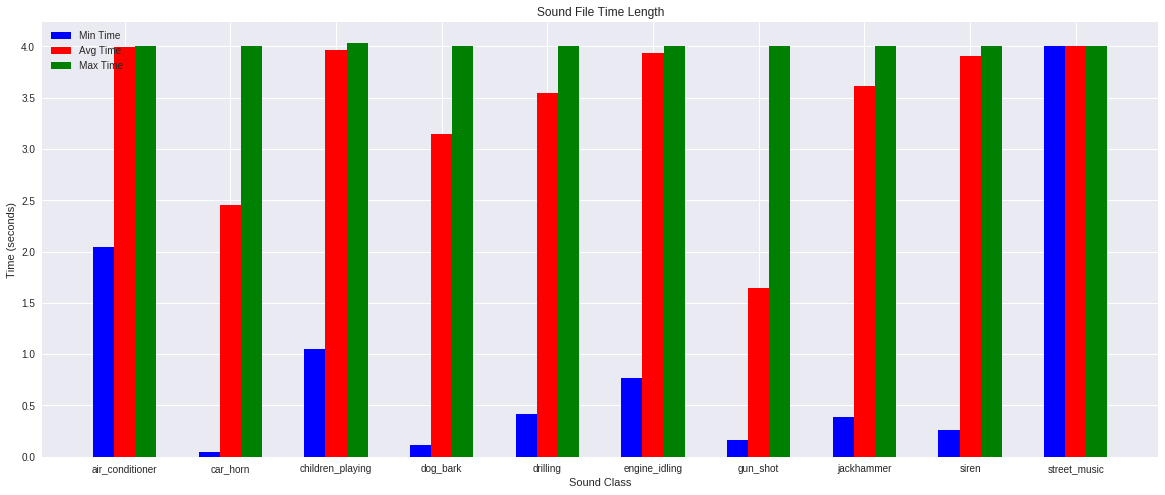

In [95]:
label_list=['air_conditioner','car_horn','children_playing','dog_bark','drilling',
            'engine_idling','gun_shot','jackhammer','siren','street_music']
plt.figure(figsize=(20,8))
mean_time = sound_data.groupby('class')['time'].mean()
max_time = sound_data.groupby('class')['time'].max()
min_time = sound_data.groupby('class')['time'].min()
x_indexes = np.arange(10)
width = 0.2
plt.bar(x_indexes-width, min_time, width=width , color='blue', label='Min Time')
plt.bar(x_indexes, mean_time, width=width, color='red', label='Avg Time')
plt.bar(x_indexes+width, max_time, width=width , color='green', label='Max Time')
plt.legend()
plt.xticks(ticks=x_indexes, labels=label_list)
plt.title('Sound File Time Length')
plt.xlabel('Sound Class')
plt.ylabel('Time (seconds)')
plt.show()

In [81]:
# add a new column with wav data length value into the dataframe
wav_len = list(map(lambda x: len(x), sound_data['wavdt']))
sound_data.insert(6,'wavdt_length',wav_len)
sound_data.head()

slice_file_name  classID             class      time     fr  \
0    100032-3-0-0.wav        3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav        2  children_playing  4.000000  22050   
2  100263-2-0-121.wav        2  children_playing  4.000000  22050   
3  100263-2-0-126.wav        2  children_playing  4.000000  22050   
4  100263-2-0-137.wav        2  children_playing  4.000000  22050   

                                               wavdt  wavdt_length  
0  [-0.0034602168, -0.005025549, -0.004653247, -0...          7002  
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...         88200  
2  [-0.0027075084, -0.0030330168, -0.001595565, -...         88200  
3  [0.00014314766, -0.00022372589, -0.0013724423,...         88200  
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...         88200

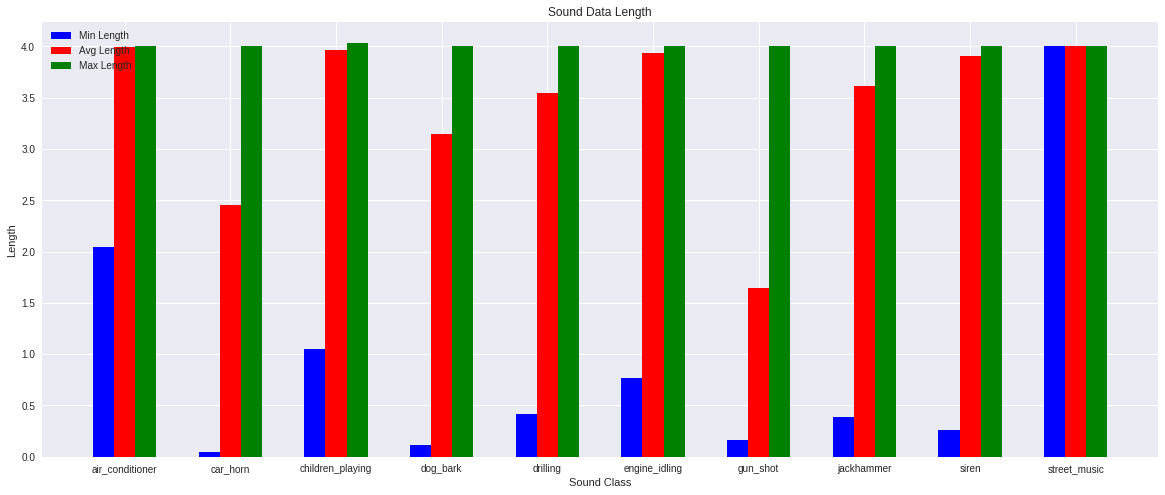

In [93]:
label_list=['air_conditioner','car_horn','children_playing','dog_bark','drilling',
            'engine_idling','gun_shot','jackhammer','siren','street_music']
plt.figure(figsize=(20,8))
mean_len = sound_data.groupby('class')['wavdt_length'].mean()
max_len = sound_data.groupby('class')['wavdt_length'].max()
min_len = sound_data.groupby('class')['wavdt_length'].min()
x_indexes = np.arange(10)
width = 0.2
plt.bar(x_indexes-width, min_time, width=width , color='blue', label='Min Length')
plt.bar(x_indexes, mean_time, width=width, color='red', label='Avg Length')
plt.bar(x_indexes+width, max_time, width=width , color='green', label='Max Length')
plt.legend()
plt.xticks(ticks=x_indexes, labels=label_list)
plt.title('Sound Data Length')
plt.xlabel('Sound Class')
plt.ylabel('Length')
plt.show()

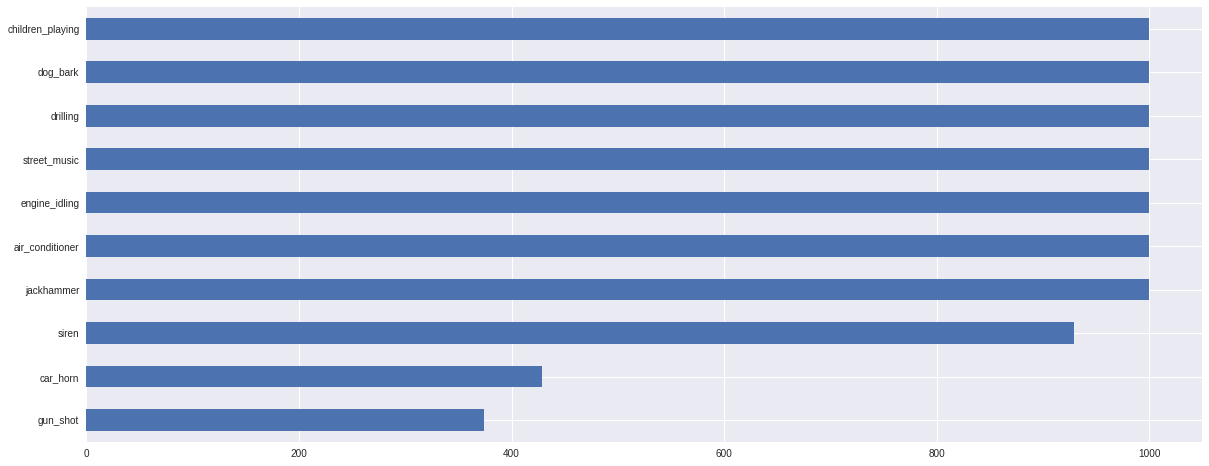

In [101]:
'''
- The dataset is significantly unbalanced for car_horn and gun_shot
- The solution for this unbalanced dataset has three: one is to duplicate the samples and the other is to use RNN to reproduce sound sample and final one is to use GAN to reproduce sound sample
- This project will use RNN to reproduce the sample with two models generated by two original sound 
'''
plt.figure(figsize=(20,8))
data['class'].value_counts().sort_values().plot.barh()
plt.show()

In [103]:
# goup dataset by 'Class' column and extract columns- 'wavdt', 'fr'
wav_info=sound_data.groupby('class').first()[['wavdt','fr']]
wav_info

wavdt     fr
class                                                                     
air_conditioner   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  22050
car_horn          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  22050
children_playing  [0.002732961, 0.0036436305, 0.0023043123, 0.00...  22050
dog_bark          [-0.0034602168, -0.005025549, -0.004653247, -0...  22050
drilling          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  22050
engine_idling     [0.04123932, 0.05967194, 0.050080467, 0.058865...  22050
gun_shot          [-9.001046e-06, 0.0005259104, 0.0009959461, 0....  22050
jackhammer        [0.001760056, 0.005091291, 0.006222161, 0.0042...  22050
siren             [0.053796418, 0.07825946, 0.058714766, 0.05484...  22050
street_music      [0.046582915, 0.08112912, 0.081553884, 0.09006...  22050

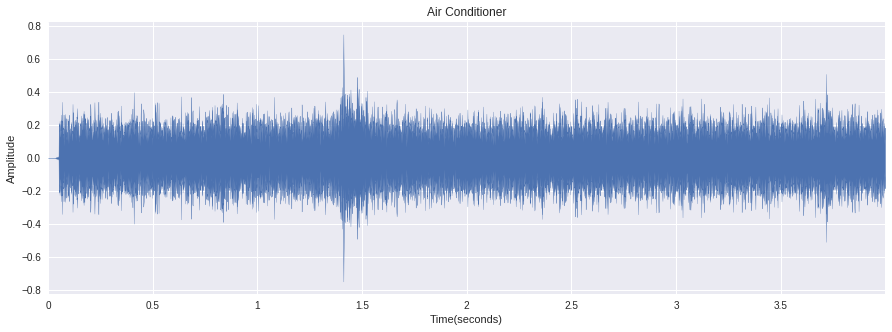

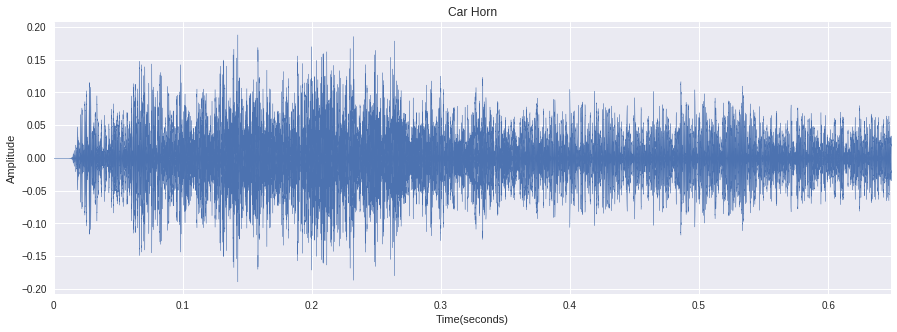

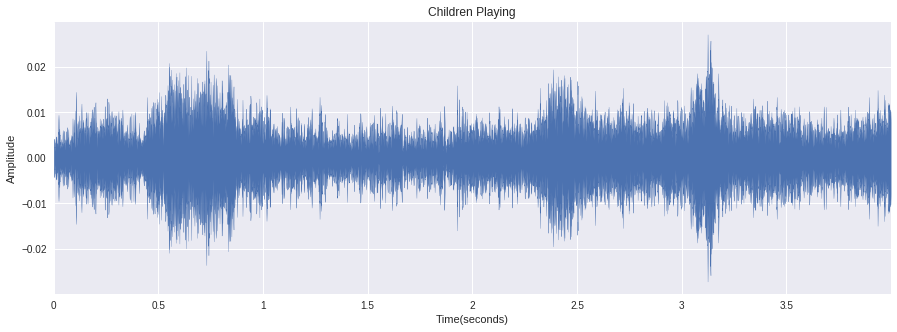

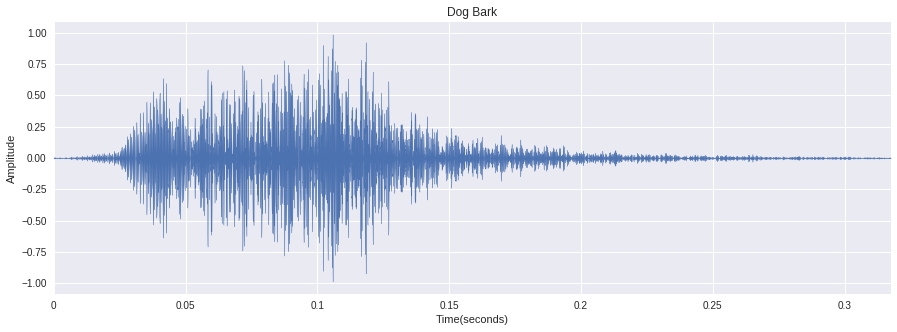

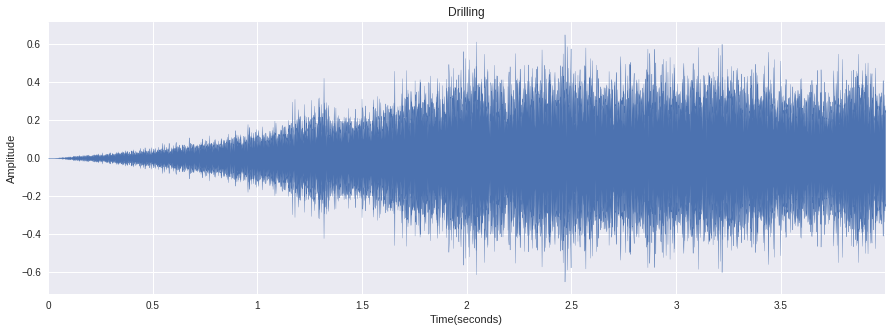

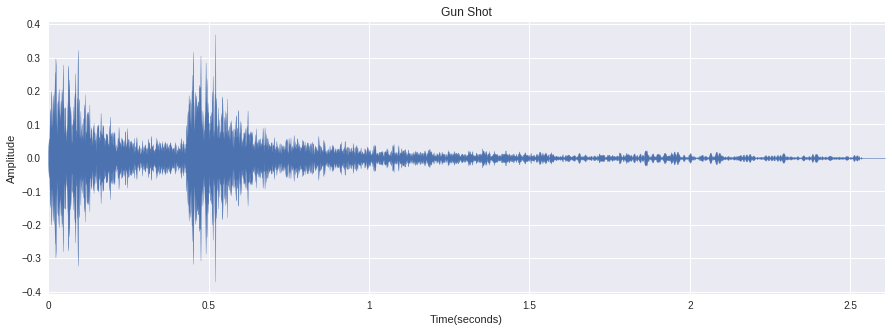

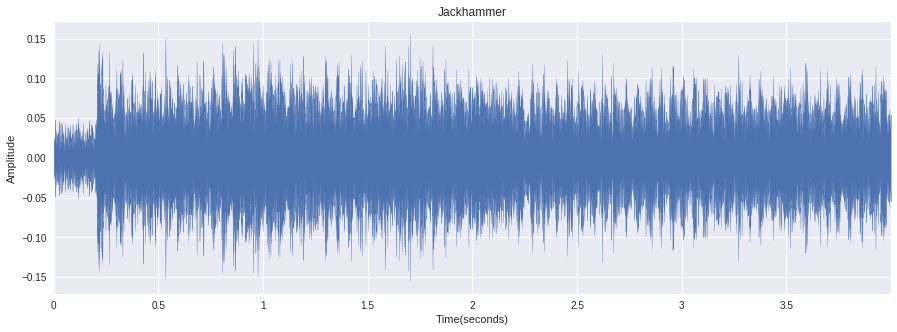

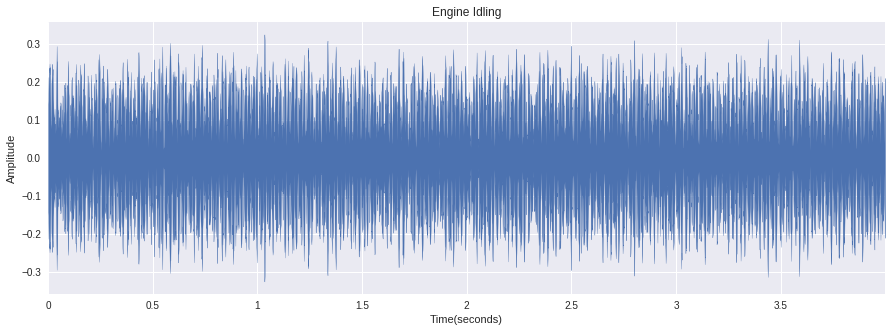

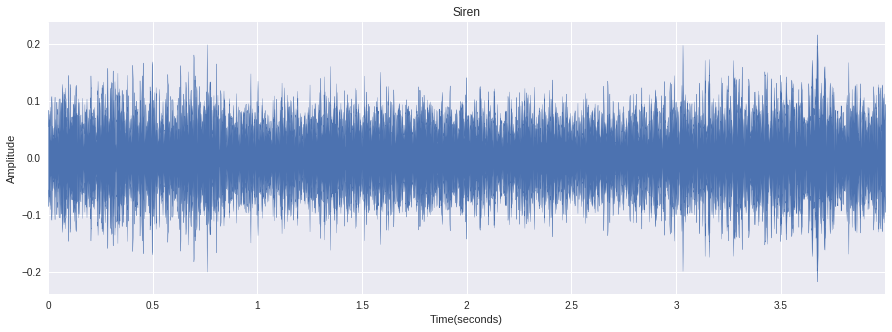

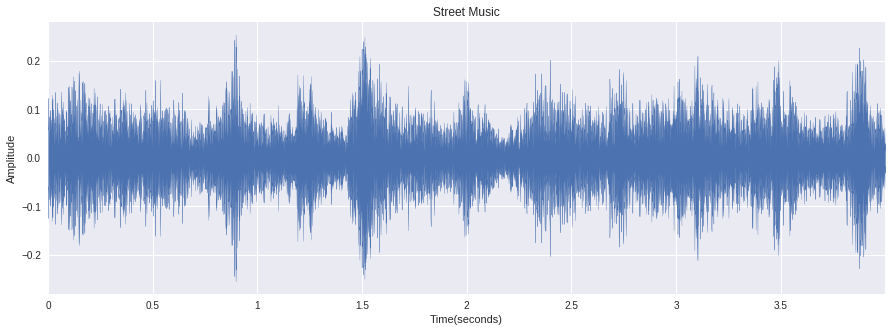

In [105]:
# plot waveform of 10 classes sound data
plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['air_conditioner'], wav_info['fr']['air_conditioner'])
plt.title('Air Conditioner')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['car_horn'], wav_info['fr']['air_conditioner'])
plt.title('Car Horn')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['children_playing'], wav_info['fr']['air_conditioner'])
plt.title('Children Playing')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['dog_bark'], wav_info['fr']['air_conditioner'])
plt.title('Dog Bark')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['drilling'], wav_info['fr']['air_conditioner'])
plt.title('Drilling')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['gun_shot'], wav_info['fr']['air_conditioner'])
plt.title('Gun Shot')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['jackhammer'], wav_info['fr']['air_conditioner'])
plt.title('Jackhammer')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['engine_idling'], wav_info['fr']['air_conditioner'])
plt.title('Engine Idling')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['siren'], wav_info['fr']['air_conditioner'])
plt.title('Siren')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
lirs_plt.waveplot(wav_info['wavdt']['street_music'], wav_info['fr']['air_conditioner'])
plt.title('Street Music')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.show()

# Reproduce car_horn samples by RNN

In [96]:
'''
- load sound data
'''
with open('./sound_dataframe','rb') as f:
    sound_data = pickle.load(f)

In [4]:
sound_data.rename(columns = {'class':'Class'}, inplace = True) 

In [5]:
sound_data.head()

slice_file_name  classID             Class      time     fr  \
0    100032-3-0-0.wav        3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav        2  children_playing         4  22050   
2  100263-2-0-121.wav        2  children_playing         4  22050   
3  100263-2-0-126.wav        2  children_playing         4  22050   
4  100263-2-0-137.wav        2  children_playing         4  22050   

                                               wavdt  
0  [-0.0034602168, -0.005025549, -0.004653247, -0...  
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...  
2  [-0.0027075084, -0.0030330168, -0.001595565, -...  
3  [0.00014314766, -0.00022372589, -0.0013724423,...  
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...

In [6]:
car_horn_dt = sound_data[sound_data.Class=='car_horn']
car_horn_sample = car_horn_dt[car_horn_dt.time==4]
car_horn_sample.head()

slice_file_name  classID     Class time     fr  \
1203  128465-1-0-0.wav        1  car_horn    4  22050   
1204  128465-1-0-1.wav        1  car_horn    4  22050   
1205  128465-1-0-2.wav        1  car_horn    4  22050   
1206  128465-1-0-3.wav        1  car_horn    4  22050   
1207  128465-1-0-4.wav        1  car_horn    4  22050   

                                                  wavdt  
1203  [-0.016877402, -0.04143462, -0.056316018, -0.0...  
1204  [-0.032067996, -0.046563108, -0.010910079, 0.0...  
1205  [-0.23556902, -0.19492573, 0.023340099, 0.0186...  
1206  [0.007920318, -0.21184216, -0.42226568, -0.460...  
1207  [0.03009685, -0.00073492597, -0.05253498, -0.0...

In [7]:
# randomly select 3 car_horn sound with the length at 4 seconds
# two for model training 
# one for model test
name_list_4s = car_horn_sample['slice_file_name'].tolist()
sd_1, sd_2, sd_3 = random.sample(range(len(name_list_4s)), 3)
sd_lst = [name_list_4s[sd_1], name_list_4s[sd_2], name_list_4s[sd_3]]
sd_lst

['72259-1-10-3.wav', '72259-1-7-15.wav', '72567-1-2-1.wav']

In [9]:
# play sound 1
ipd.Audio(f'./DataFolder/{sd_lst[0]}') 

In [10]:
# play sound 2
ipd.Audio(f'./DataFolder/{sd_lst[1]}') 

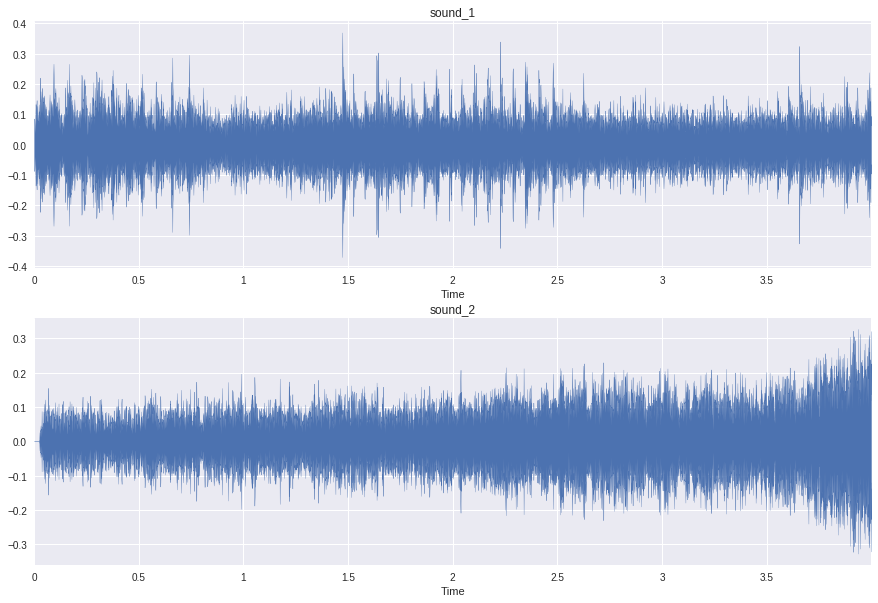

In [9]:
# plot two sound wavform
sd_1_dt = car_horn_sample[car_horn_sample['slice_file_name']==sd_lst[0]]['wavdt'].tolist()[0]
sd_2_dt = car_horn_sample[car_horn_sample['slice_file_name']==sd_lst[1]]['wavdt'].tolist()[0]
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
lirs_plt.waveplot(sd_1_dt)
plt.title('sound_1')
plt.subplot(2,1,2)
lirs_plt.waveplot(sd_2_dt)
plt.title('sound_2')
plt.show()

In [11]:
'''
- univariate_data is the function to generate training dataset
- generate 2 datasets for rnn training 
- use 50 history data to predict 51st data
'''
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size-1
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [16]:
uni_data1, uni_label1 = univariate_data(dataset = sd_1_dt, start_index=0, end_index=None, history_size=500, target_size=1)
uni_data2, uni_label2 = univariate_data(dataset = sd_2_dt, start_index=0, end_index=None, history_size=500, target_size=1)
print(f'uni_data1 shape:{uni_data1.shape}, uni_label1 shape:{uni_label1.shape}')
print(f'uni_data2 shape:{uni_data2.shape}, uni_label2 shape:{uni_label2.shape}')

uni_data1 shape:(87698, 500, 1), uni_label1 shape:(87698,)
uni_data2 shape:(87698, 500, 1), uni_label2 shape:(87698,)


In [14]:
# build RNN model
def build_rnn():
    time_steps=500
    input_feature = 1
    ipt = Input(shape=(500,1))
    opt = LSTM(1, return_sequences = True)(ipt)
    opt = Flatten()(opt)
    dense_opt1 = Dense(128, activation='relu')(opt)
    dense_opt2 = Dense(1)(dense_opt1)
    model = Model(ipt, dense_opt2)
    return model

rnn_1 = build_rnn()
rnn_1.compile(optimizer= 'RMSprop', loss='mae')
rnn_2 = build_rnn()
rnn_2.compile(optimizer= 'RMSprop', loss='mae')
rnn_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 1)            12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 64,269
Trainable params: 64,269
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train model_1
history = rnn_1.fit(x= uni_data1, 
                    y= uni_label1, 
                    batch_size = 128,
                    epochs= 20,
                    validation_split=0.2,
                   )

rnn_1.save('./rnn_1.h5')

Train on 70158 samples, validate on 17540 samples
Epoch 1/20
70158/70158 [==============================] - 146s 2ms/step - loss: 0.0565 - val_loss: 0.0553
Epoch 2/20
70158/70158 [==============================] - 139s 2ms/step - loss: 0.0442 - val_loss: 0.0475
Epoch 3/20
70158/70158 [==============================] - 139s 2ms/step - loss: 0.0396 - val_loss: 0.0450
Epoch 4/20
70158/70158 [==============================] - 137s 2ms/step - loss: 0.0370 - val_loss: 0.0422
Epoch 5/20
70158/70158 [==============================] - 137s 2ms/step - loss: 0.0357 - val_loss: 0.0418
Epoch 6/20
70158/70158 [==============================] - 136s 2ms/step - loss: 0.0349 - val_loss: 0.0423
Epoch 7/20
70158/70158 [==============================] - 137s 2ms/step - loss: 0.0343 - val_loss: 0.0422
Epoch 8/20
70158/70158 [==============================] - 136s 2ms/step - loss: 0.0336 - val_loss: 0.0414
Epoch 9/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0331 - val_loss: 0.0

In [16]:
# train model_2
history = rnn_2.fit(x= uni_data2, 
                    y= uni_label2, 
                    batch_size = 128,
                    epochs= 20,
                    validation_split=0.2,
                   )

rnn_2.save('./rnn_2.h5')

Train on 70158 samples, validate on 17540 samples
Epoch 1/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0331 - val_loss: 0.0639
Epoch 2/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0259 - val_loss: 0.0701
Epoch 3/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0228 - val_loss: 0.0759
Epoch 4/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0204 - val_loss: 0.0744
Epoch 5/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0185 - val_loss: 0.0724
Epoch 6/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0171 - val_loss: 0.0633
Epoch 7/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0158 - val_loss: 0.0583
Epoch 8/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0149 - val_loss: 0.0566
Epoch 9/20
70158/70158 [==============================] - 135s 2ms/step - loss: 0.0141 - val_loss: 0.0

In [18]:
# random select on sound and test rnn_1 and rnn_2
sd_3_dt = car_horn_sample[car_horn_sample['slice_file_name']==sd_lst[2]]['wavdt'].tolist()[0]
ipd.Audio(f'./DataFolder/{sd_lst[2]}') 

In [19]:
# generate test data
uni_data, uni_label = univariate_data(dataset = sd_3_dt, start_index=0, end_index=None, history_size=500, target_size=1)
print(f'uni_data shape:{uni_data.shape}, uni_label shape:{uni_label.shape}')

uni_data shape:(87698, 500, 1), uni_label shape:(87698,)


In [21]:
# reproduce sample & plotting
predict_1 = rnn_1.predict(uni_data, batch_size=128, verbose=1, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
predict_2 = rnn_2.predict(uni_data, batch_size=128, verbose=1, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

87698/87698 [==============================] - 62s 708us/step


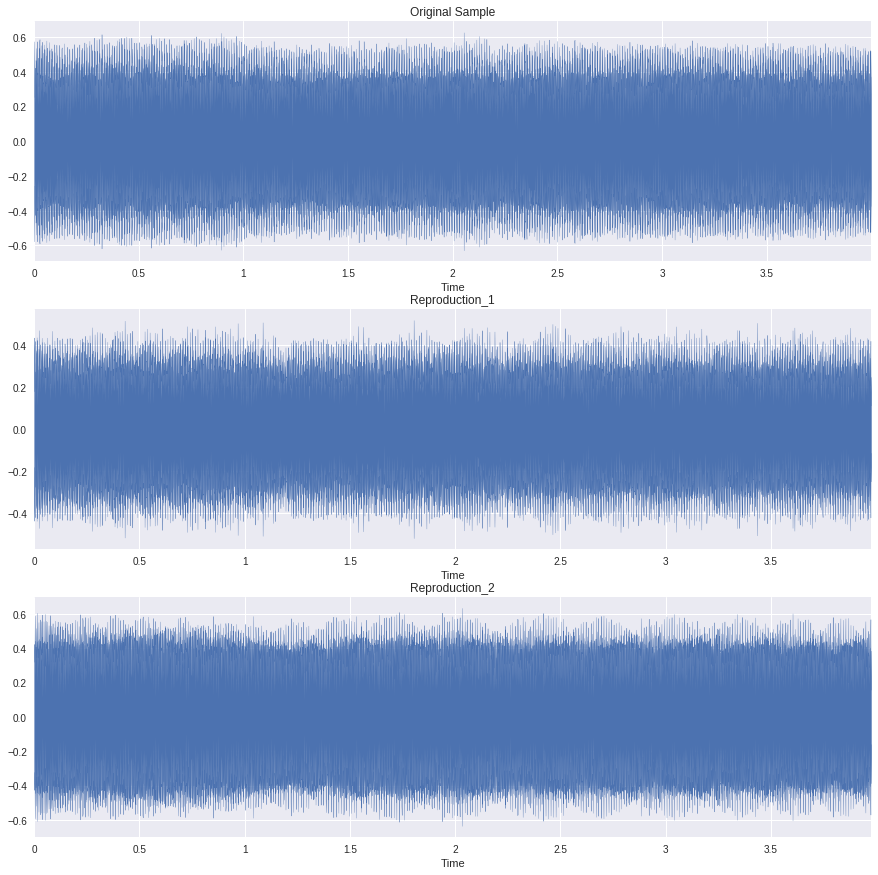

In [23]:
# sample reproduction
predict_1 = predict_1.reshape(predict_1.shape[0])
predict_2 = predict_2.reshape(predict_2.shape[0])
# plotting
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title('Original Sample')
lirs_plt.waveplot(sd_3_dt)
plt.subplot(3,1,2)
lirs_plt.waveplot(predict_1)
plt.title('Reproduction_1')
plt.subplot(3,1,3)
lirs_plt.waveplot(predict_2)
plt.title('Reproduction_2')
plt.show()

In [8]:
rnn_1 = load_model('./rnn_1.h5')
rnn_2 = load_model('./rnn_2.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            64269       input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            64269       input_1[0][0]                    
Total params: 128,538
Trainable params: 128,538
Non-trainable params: 0
__________________________________________________________________________________________________


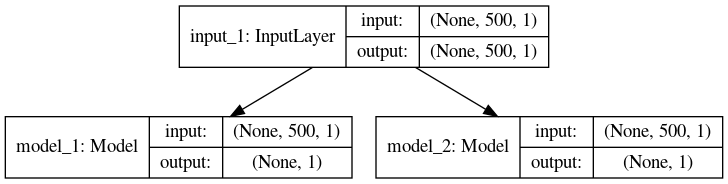

In [9]:
# merge two models into car_horn_model
timesteps=500
input_dim=1

ipt = Input(shape=(timesteps, input_dim))
rnn_1.layers.pop(0)
rnn_2.layers.pop(0)
opt1 = rnn_1(ipt)
opt2 = rnn_2(ipt)
car_horn_model=Model(ipt,[opt1, opt2])
car_horn_model.compile(optimizer= 'RMSprop', loss='mae')
car_horn_model.summary()
from keras.utils.vis_utils import plot_model
plot_model(car_horn_model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# reproduce car_horn sound samples
car_horn_samples=[]
count = 0
for index, row in car_horn_dt.iterrows():
    name = row['slice_file_name']
    count +=1
    uni_data, uni_label = univariate_data(dataset = row['wavdt'], start_index=0, end_index=None, history_size=500, target_size=1)
    pt_1, pt_2 = car_horn_model.predict(uni_data, batch_size=128, verbose=1, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    for pt in [pt_1, pt_2]:
        sample = [f'car_horn_{index}.wav', row['classID'], row['Class'], row['time'], row['fr'], pt.reshape(pt.shape[0])]
        car_horn_samples.append(sample)
    print(f'{count}: {name} reproduction is done...')

13798/13798 [==============================] - 17s 1ms/step
1: 100648-1-0-0.wav reproduction is done...
22651/22651 [==============================] - 27s 1ms/step
2: 100648-1-1-0.wav reproduction is done...
8436/8436 [==============================] - 10s 1ms/step
3: 100648-1-2-0.wav reproduction is done...
35219/35219 [==============================] - 42s 1ms/step
4: 100648-1-3-0.wav reproduction is done...
40511/40511 [==============================] - 48s 1ms/step
5: 100648-1-4-0.wav reproduction is done...
12705/12705 [==============================] - 15s 1ms/step
6: 107090-1-0-0.wav reproduction is done...
17784/17784 [==============================] - 21s 1ms/step
7: 107090-1-1-0.wav reproduction is done...
12191/12191 [==============================] - 14s 1ms/step
8: 117536-1-0-0.wav reproduction is done...
4461/4461 [==============================] - 5s 1ms/step
9: 118070-1-0-0.wav reproduction is done...
5121/5121 [==============================] - 6s 1ms/step
10: 118496-1

6113/6113 [==============================] - 7s 1ms/step
80: 171249-1-2-0.wav reproduction is done...
821/821 [==============================] - 1s 1ms/step
81: 17307-1-0-0.wav reproduction is done...
65207/65207 [==============================] - 75s 1ms/step
82: 174840-1-0-0.wav reproduction is done...
39409/39409 [==============================] - 46s 1ms/step
83: 174841-1-0-0.wav reproduction is done...
10082/10082 [==============================] - 12s 1ms/step
84: 175842-1-0-0.wav reproduction is done...
19269/19269 [==============================] - 22s 1ms/step
85: 175843-1-0-0.wav reproduction is done...
19123/19123 [==============================] - 22s 1ms/step
86: 175844-1-0-0.wav reproduction is done...
15778/15778 [==============================] - 18s 1ms/step
87: 175845-1-0-0.wav reproduction is done...
32353/32353 [==============================] - 37s 1ms/step
88: 175846-1-0-0.wav reproduction is done...
17502/17502 [==============================] - 20s 1ms/step
89: 

5578/5578 [==============================] - 6s 1ms/step
236: 45256-1-0-0.wav reproduction is done...
87698/87698 [==============================] - 100s 1ms/step
237: 46391-1-0-0.wav reproduction is done...
23533/23533 [==============================] - 27s 1ms/step
238: 46391-1-1-0.wav reproduction is done...
56564/56564 [==============================] - 65s 1ms/step
239: 49974-1-0-0.wav reproduction is done...
8759/8759 [==============================] - 10s 1ms/step
240: 52102-1-0-0.wav reproduction is done...
25076/25076 [==============================] - 29s 1ms/step
241: 54086-1-0-0.wav reproduction is done...
25958/25958 [==============================] - 30s 1ms/step
242: 54086-1-1-0.wav reproduction is done...
27887/27887 [==============================] - 32s 1ms/step
243: 54086-1-2-0.wav reproduction is done...
87698/87698 [==============================] - 100s 1ms/step
244: 54187-1-0-0.wav reproduction is done...
87698/87698 [==============================] - 100s 1ms/st

87698/87698 [==============================] - 99s 1ms/step
391: 7389-1-4-14.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
392: 7389-1-4-15.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
393: 7389-1-4-2.wav reproduction is done...
87698/87698 [==============================] - 98s 1ms/step
394: 7389-1-4-3.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
395: 7389-1-4-4.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
396: 7389-1-4-5.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
397: 7389-1-4-6.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
398: 7389-1-4-7.wav reproduction is done...
87698/87698 [==============================] - 100s 1ms/step
399: 7389-1-4-8.wav reproduction is done...
87698/87698 [==============================] - 99s 1ms/step
4

In [13]:
'''
- Save car_horn reproduction as a binary for furthur analysis
'''
with open('./car_horn_reproduction','wb') as f:
    pickle.dump(car_horn_samples, f)

# Reproduce gun_shot samples by RNN (Same process like car_horn reproduction)

In [17]:
'''
- load sound data
'''
with open('./sound_dataframe','rb') as f:
    sound_data = pickle.load(f)

gun_shot sample list: ['135527-6-14-8.wav', '135527-6-14-0.wav', '135527-6-14-5.wav']


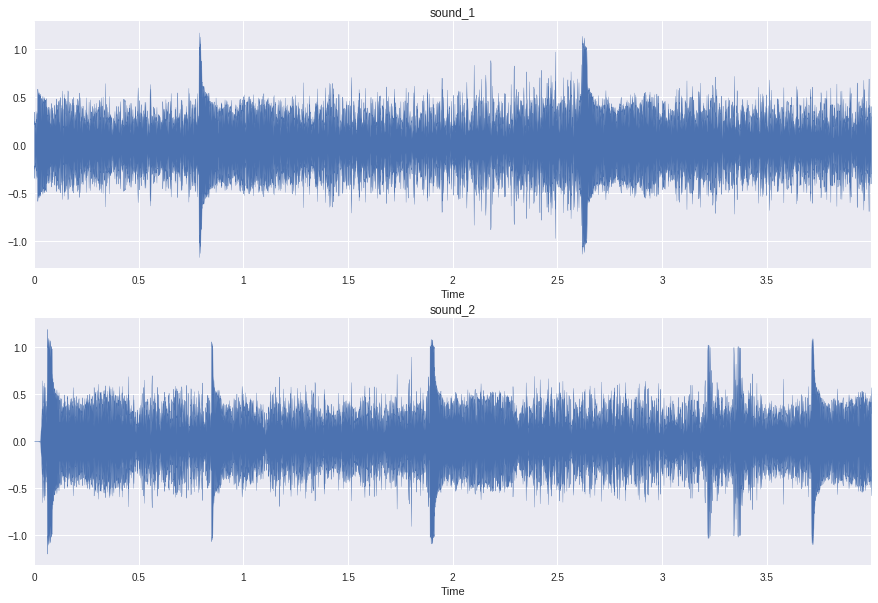

In [108]:
# extract all gun_shot with 4 seconds
gun_shot_dt = sound_data[sound_data.Class=='gun_shot']
gun_shot_sample = gun_shot_dt[gun_shot_dt.time==4]

# randomly select 3 car_horn sound with the length at 4 seconds
# two for model training 
# one for model test
name_list_4s = gun_shot_sample['slice_file_name'].tolist()
sd_1, sd_2, sd_3 = random.sample(range(len(name_list_4s)), 3)
sd_lst = [name_list_4s[sd_1], name_list_4s[sd_2], name_list_4s[sd_3]]
print(f'gun_shot sample list: {sd_lst}')

# extract the waveform data
sd_1_dt = gun_shot_sample[gun_shot_sample['slice_file_name']==sd_lst[0]]['wavdt'].tolist()[0]
sd_2_dt = gun_shot_sample[gun_shot_sample['slice_file_name']==sd_lst[1]]['wavdt'].tolist()[0]
sd_3_dt = gun_shot_sample[gun_shot_sample['slice_file_name']==sd_lst[2]]['wavdt'].tolist()[0]
# plot two sound wavform
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
lirs_plt.waveplot(sd_1_dt)
plt.title('sound_1')
plt.subplot(2,1,2)
lirs_plt.waveplot(sd_2_dt)
plt.title('sound_2')
plt.show()


In [55]:
'''
- univariate_data is the function to generate training dataset
- generate 2 datasets for rnn training 
- use 50 history data to predict 51st data
'''
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size-1
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

uni_data1, uni_label1 = univariate_data(dataset = sd_1_dt, start_index=0, end_index=None, history_size=80, target_size=1)
uni_data2, uni_label2 = univariate_data(dataset = sd_2_dt, start_index=0, end_index=None, history_size=80, target_size=1)
uni_data3, uni_label3 = univariate_data(dataset = sd_3_dt, start_index=0, end_index=None, history_size=80, target_size=1)
print(f'uni_data1 shape:{uni_data1.shape}, uni_label1 shape:{uni_label1.shape}')
print(f'uni_data2 shape:{uni_data2.shape}, uni_label2 shape:{uni_label2.shape}')
print(f'uni_data3 shape:{uni_data3.shape}, uni_label2 shape:{uni_label3.shape}')

uni_data1 shape:(88118, 80, 1), uni_label1 shape:(88118,)
uni_data2 shape:(88118, 80, 1), uni_label2 shape:(88118,)
uni_data3 shape:(88118, 80, 1), uni_label2 shape:(88118,)


In [64]:
# build RNN model
def build_rnn():
    time_steps=80
    input_feature = 1
    ipt = Input(shape=(time_steps,input_feature))
    opt = LSTM(1, return_sequences = True)(ipt)
    opt = Flatten()(opt)
    dense_opt1 = Dense(128, activation='relu')(opt)
    dense_opt2 = Dense(1)(dense_opt1)
    model = Model(ipt, dense_opt2)
    model.compile(optimizer= 'RMSprop', loss='mae')
    return model

rnn_3 = build_rnn()
rnn_4 = build_rnn()
rnn_3.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 80, 1)             0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 80, 1)             12        
_________________________________________________________________
flatten_25 (Flatten)         (None, 80)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               10368     
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 129       
Total params: 10,509
Trainable params: 10,509
Non-trainable params: 0
_________________________________________________________________


In [65]:
# train model_3
history = rnn_3.fit(x= uni_data1, 
                    y= uni_label1, 
                    batch_size = 128,
                    epochs= 20,
                    validation_split=0.2,
                   )

rnn_3.save('./rnn_gun_shot_1.h5')

Train on 70494 samples, validate on 17624 samples
Epoch 1/20
70494/70494 [==============================] - 28s 392us/step - loss: 0.1005 - val_loss: 0.0934
Epoch 2/20
70494/70494 [==============================] - 26s 365us/step - loss: 0.0823 - val_loss: 0.0847
Epoch 3/20
70494/70494 [==============================] - 25s 356us/step - loss: 0.0763 - val_loss: 0.0782
Epoch 4/20
70494/70494 [==============================] - 24s 347us/step - loss: 0.0730 - val_loss: 0.0740
Epoch 5/20
70494/70494 [==============================] - 25s 349us/step - loss: 0.0709 - val_loss: 0.0732
Epoch 6/20
70494/70494 [==============================] - 26s 367us/step - loss: 0.0695 - val_loss: 0.0726
Epoch 7/20
70494/70494 [==============================] - 25s 348us/step - loss: 0.0684 - val_loss: 0.0728
Epoch 8/20
70494/70494 [==============================] - 26s 366us/step - loss: 0.0677 - val_loss: 0.0710
Epoch 9/20
70494/70494 [==============================] - 26s 369us/step - loss: 0.0669 - val_

In [66]:
# train model_4
history = rnn_4.fit(x= uni_data2, 
                    y= uni_label2, 
                    batch_size = 128,
                    epochs= 20,
                    validation_split=0.2,
                   )

rnn_4.save('./rnn_gun_shot_2.h5')

Train on 70494 samples, validate on 17624 samples
Epoch 1/20
70494/70494 [==============================] - 27s 378us/step - loss: 0.1048 - val_loss: 0.0669
Epoch 2/20
70494/70494 [==============================] - 32s 461us/step - loss: 0.0899 - val_loss: 0.0532
Epoch 3/20
70494/70494 [==============================] - 26s 363us/step - loss: 0.0845 - val_loss: 0.0523
Epoch 4/20
70494/70494 [==============================] - 25s 351us/step - loss: 0.0816 - val_loss: 0.0503
Epoch 5/20
70494/70494 [==============================] - 24s 343us/step - loss: 0.0797 - val_loss: 0.0464
Epoch 6/20
70494/70494 [==============================] - 25s 353us/step - loss: 0.0784 - val_loss: 0.0441
Epoch 7/20
70494/70494 [==============================] - 23s 330us/step - loss: 0.0774 - val_loss: 0.0435
Epoch 8/20
70494/70494 [==============================] - 25s 349us/step - loss: 0.0767 - val_loss: 0.0440
Epoch 9/20
70494/70494 [==============================] - 24s 344us/step - loss: 0.0760 - val_

In [98]:
rnn_3 = load_model('./rnn_gun_shot_1.h5')
rnn_4 = load_model('./rnn_gun_shot_2.h5')

Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 80, 1)        0                                            
__________________________________________________________________________________________________
model_45 (Model)                (None, 1)            10509       input_57[0][0]                   
__________________________________________________________________________________________________
model_46 (Model)                (None, 1)            10509       input_57[0][0]                   
Total params: 21,018
Trainable params: 21,018
Non-trainable params: 0
__________________________________________________________________________________________________


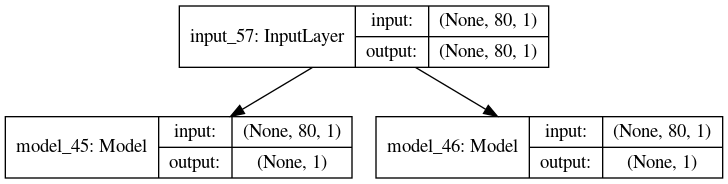

In [99]:
# merget two models into gun_shot_model
timesteps=80
input_dim=1

ipt = Input(shape=(timesteps, input_dim))
rnn_3.layers.pop(0)
rnn_4.layers.pop(0)
opt1 = rnn_3(ipt)
opt2 = rnn_4(ipt)
gun_shot_model=Model(ipt,[opt1, opt2])
gun_shot_model.compile(optimizer= 'RMSprop', loss='mae')
gun_shot_model.summary()
from keras.utils.vis_utils import plot_model
plot_model(gun_shot_model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

88118/88118 [==============================] - 19s 220us/step


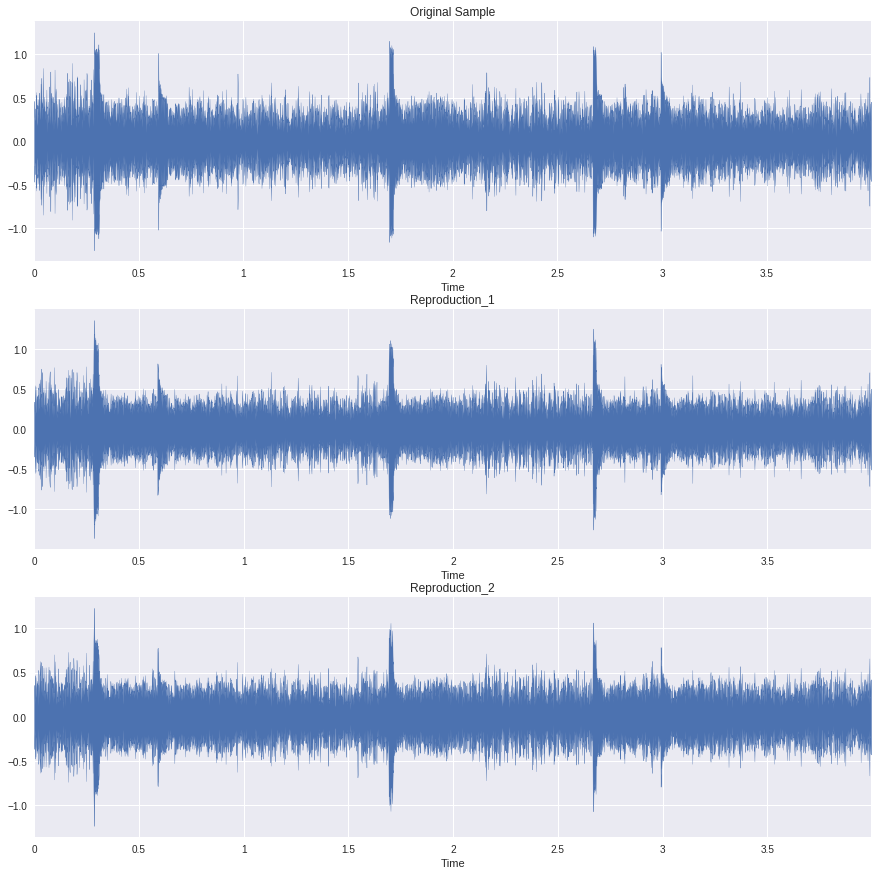

In [102]:
# reproduce sample & plotting
pt_1, pt_2 = gun_shot_model.predict(uni_data3, batch_size=128, verbose=1, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

# sample reproduction
pt_1 = pt_1.reshape(pt_1.shape[0])
pt_2 = pt_2.reshape(pt_2.shape[0])
# plotting
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title('Original Sample')
lirs_plt.waveplot(sd_3_dt)
plt.subplot(3,1,2)
lirs_plt.waveplot(pt_1)
plt.title('Reproduction_1')
plt.subplot(3,1,3)
lirs_plt.waveplot(pt_2)
plt.title('Reproduction_2')
plt.show()

In [104]:
# reproduce gun_shot sound samples
gun_shot_samples=[]
count = 0
for index, row in gun_shot_dt.iterrows():
    name = row['slice_file_name']
    count +=1
    uni_data, uni_label = univariate_data(dataset = row['wavdt'], start_index=0, end_index=None, history_size=80, target_size=1)
    pt_1, pt_2 = gun_shot_model.predict(uni_data, batch_size=128, verbose=1, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    for pt in [pt_1, pt_2]:
        sample = [f'car_horn_{index}.wav', row['classID'], row['Class'], row['time'], row['fr'], pt.reshape(pt.shape[0])]
        gun_shot_samples.append(sample)
    print(f'{count}: {name} reproduction is done...')

57469/57469 [==============================] - 13s 225us/step
1: 102305-6-0-0.wav reproduction is done...
25276/25276 [==============================] - 6s 221us/step
2: 106955-6-0-0.wav reproduction is done...
32993/32993 [==============================] - 7s 223us/step
3: 110622-6-0-0.wav reproduction is done...
28804/28804 [==============================] - 6s 223us/step
4: 111048-6-0-0.wav reproduction is done...
69285/69285 [==============================] - 17s 251us/step
5: 122690-6-0-0.wav reproduction is done...
41813/41813 [==============================] - 10s 245us/step
6: 131571-6-0-0.wav reproduction is done...
30954/30954 [==============================] - 8s 252us/step
7: 133797-6-0-0.wav reproduction is done...
42914/42914 [==============================] - 11s 253us/step
8: 133797-6-1-0.wav reproduction is done...
38927/38927 [==============================] - 9s 231us/step
9: 133797-6-2-0.wav reproduction is done...
32451/32451 [==============================] - 8s 2

26804/26804 [==============================] - 6s 216us/step
78: 135544-6-4-0.wav reproduction is done...
36521/36521 [==============================] - 8s 216us/step
79: 135544-6-5-0.wav reproduction is done...
32915/32915 [==============================] - 7s 216us/step
80: 135544-6-6-0.wav reproduction is done...
29245/29245 [==============================] - 6s 216us/step
81: 135544-6-7-0.wav reproduction is done...
14583/14583 [==============================] - 3s 212us/step
82: 135544-6-8-0.wav reproduction is done...
31670/31670 [==============================] - 7s 218us/step
83: 135544-6-9-0.wav reproduction is done...
73786/73786 [==============================] - 16s 217us/step
84: 136399-6-0-0.wav reproduction is done...
81062/81062 [==============================] - 17s 215us/step
85: 136399-6-1-0.wav reproduction is done...
71581/71581 [==============================] - 15s 216us/step
86: 136399-6-2-0.wav reproduction is done...
64904/64904 [==============================

25691/25691 [==============================] - 5s 209us/step
155: 157207-6-2-0.wav reproduction is done...
19703/19703 [==============================] - 4s 205us/step
156: 157207-6-3-0.wav reproduction is done...
20645/20645 [==============================] - 4s 208us/step
157: 157207-6-4-0.wav reproduction is done...
45736/45736 [==============================] - 10s 211us/step
158: 157207-6-5-0.wav reproduction is done...
27701/27701 [==============================] - 6s 206us/step
159: 157207-6-6-0.wav reproduction is done...
22306/22306 [==============================] - 5s 208us/step
160: 157207-6-7-0.wav reproduction is done...
22827/22827 [==============================] - 5s 210us/step
161: 157207-6-8-0.wav reproduction is done...
45996/45996 [==============================] - 10s 208us/step
162: 157207-6-9-0.wav reproduction is done...
49972/49972 [==============================] - 10s 208us/step
163: 157799-6-0-0.wav reproduction is done...
25262/25262 [=====================

15954/15954 [==============================] - 3s 205us/step
232: 162435-6-3-0.wav reproduction is done...
39538/39538 [==============================] - 8s 206us/step
233: 162436-6-0-0.wav reproduction is done...
14692/14692 [==============================] - 3s 204us/step
234: 163460-6-0-0.wav reproduction is done...
17265/17265 [==============================] - 4s 209us/step
235: 164646-6-0-0.wav reproduction is done...
16370/16370 [==============================] - 3s 206us/step
236: 164667-6-0-0.wav reproduction is done...
36521/36521 [==============================] - 8s 209us/step
237: 169261-6-0-0.wav reproduction is done...
57005/57005 [==============================] - 12s 205us/step
238: 174282-6-0-0.wav reproduction is done...
57689/57689 [==============================] - 12s 207us/step
239: 174282-6-1-0.wav reproduction is done...
83385/83385 [==============================] - 17s 207us/step
240: 174282-6-2-0.wav reproduction is done...
56132/56132 [=====================

In [106]:
'''
- Save gun_shot reproduction as a binary for furthur analysis
'''
with open('./gun_shot_reproduction','wb') as f:
    pickle.dump(gun_shot_samples, f)

# Balance Dataset

In [126]:
'''
- load sound data
'''
with open('./sound_dataframe','rb') as f:
    sound_data = pickle.load(f)

In [127]:
sound_data.head()

slice_file_name  classID             class      time     fr  \
0    100032-3-0-0.wav        3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav        2  children_playing         4  22050   
2  100263-2-0-121.wav        2  children_playing         4  22050   
3  100263-2-0-126.wav        2  children_playing         4  22050   
4  100263-2-0-137.wav        2  children_playing         4  22050   

                                               wavdt  
0  [-0.0034602168, -0.005025549, -0.004653247, -0...  
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...  
2  [-0.0027075084, -0.0030330168, -0.001595565, -...  
3  [0.00014314766, -0.00022372589, -0.0013724423,...  
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...

In [128]:
with open('./gun_shot_reproduction','rb') as f:
    gun_shot_samples = pickle.load(f)
with open('./car_horn_reproduction','rb') as f:
    car_horn_samples = pickle.load(f)

In [129]:
len(car_horn_samples)

858

In [130]:
sound_samples = gun_shot_samples[0:(748-150)] + car_horn_samples[0:(858-250)]
sound_samples[0:2]

[['car_horn_106.wav',
  6,
  'gun_shot',
  2.6100226757369613,
  22050,
  array([-0.01126682, -0.02222015, -0.03832689, ...,  0.0029884 ,
          0.0029884 ,  0.0029884 ], dtype=float32)],
 ['car_horn_106.wav',
  6,
  'gun_shot',
  2.6100226757369613,
  22050,
  array([-0.00654765, -0.01259505, -0.02293085, ...,  0.00849355,
          0.00849355,  0.00849355], dtype=float32)]]

In [131]:
sound_data.head()

slice_file_name  classID             class      time     fr  \
0    100032-3-0-0.wav        3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav        2  children_playing         4  22050   
2  100263-2-0-121.wav        2  children_playing         4  22050   
3  100263-2-0-126.wav        2  children_playing         4  22050   
4  100263-2-0-137.wav        2  children_playing         4  22050   

                                               wavdt  
0  [-0.0034602168, -0.005025549, -0.004653247, -0...  
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...  
2  [-0.0027075084, -0.0030330168, -0.001595565, -...  
3  [0.00014314766, -0.00022372589, -0.0013724423,...  
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...

In [132]:
sample_data = pd.DataFrame(np.array(sound_samples), columns=['slice_file_name','classID','Class','time','fr','wavdt'])
sample_data.head()

slice_file_name classID     Class     time     fr  \
0  car_horn_106.wav       6  gun_shot  2.61002  22050   
1  car_horn_106.wav       6  gun_shot  2.61002  22050   
2  car_horn_496.wav       6  gun_shot  1.15002  22050   
3  car_horn_496.wav       6  gun_shot  1.15002  22050   
4  car_horn_611.wav       6  gun_shot      1.5  22050   

                                               wavdt  
0  [-0.011266823, -0.022220146, -0.03832689, -0.0...  
1  [-0.006547652, -0.01259505, -0.022930846, 0.00...  
2  [-0.0012641856, -0.0027157287, -0.0054173516, ...  
3  [0.0063782893, 0.0042388514, 0.0012699328, 0.0...  
4  [0.06761793, 0.2676241, 0.4261961, 0.18250462,...

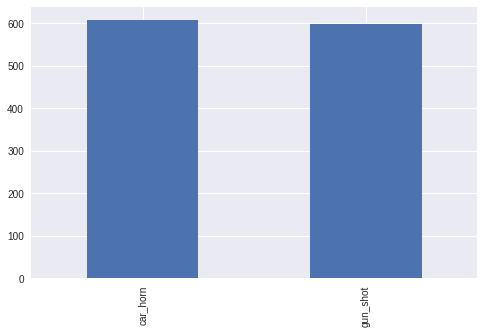

In [133]:
sample_data['Class'].value_counts().plot.bar(figsize=(8,5))
plt.show()

In [134]:
# concatenate two dataframe
sound_data = pd.concat([sound_data, sample_data],axis=0, sort=False, ignore_index=True)
sound_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   slice_file_name  9938 non-null   object
 1   classID          9938 non-null   object
 2   class            8732 non-null   object
 3   time             9938 non-null   object
 4   fr               9938 non-null   object
 5   wavdt            9938 non-null   object
 6   Class            1206 non-null   object
dtypes: object(7)
memory usage: 543.6+ KB


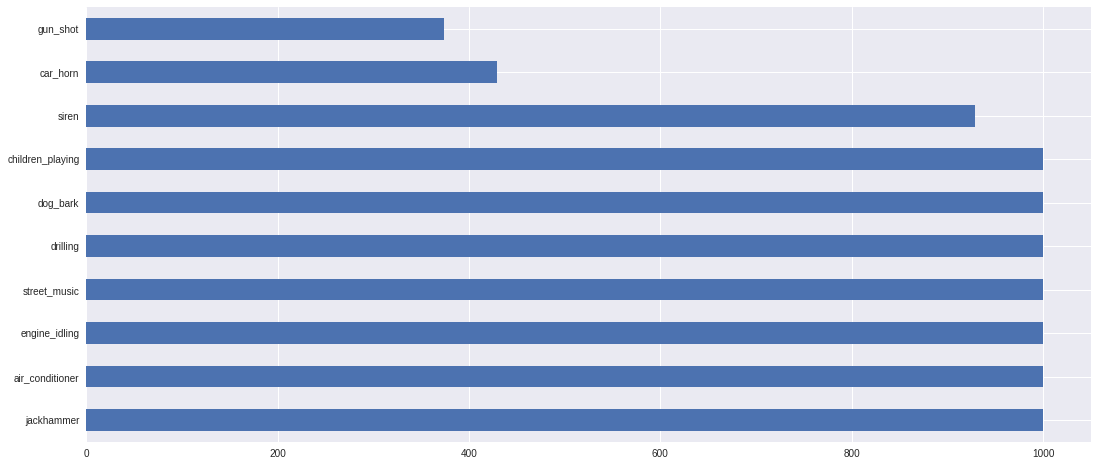

In [141]:
# car_horn and gun_shot are a bit more than 1000, but the dataset is balacned
sound_data['class'].value_counts().plot.barh(figsize=(18,8))
plt.show()

In [43]:
sound_data.sort_index(axis=0)

slice_file_name classID             Class      time     fr  \
0       100032-3-0-0.wav       3          dog_bark  0.317551  22050   
1     100263-2-0-117.wav       2  children_playing         4  22050   
2     100263-2-0-121.wav       2  children_playing         4  22050   
3     100263-2-0-126.wav       2  children_playing         4  22050   
4     100263-2-0-137.wav       2  children_playing         4  22050   
...                  ...     ...               ...       ...    ...   
9933   car_horn_7524.wav       1          car_horn         4  22050   
9934   car_horn_7525.wav       1          car_horn         4  22050   
9935   car_horn_7525.wav       1          car_horn         4  22050   
9936   car_horn_7526.wav       1          car_horn         4  22050   
9937   car_horn_7526.wav       1          car_horn         4  22050   

                                                  wavdt  
0     [-0.0034602168, -0.005025549, -0.004653247, -0...  
1     [0.002732961, 0.0036436305, 0.0023043123, 0.00...  
2     [-0.0027075084, -0.0030330168, -0.001595565, -...  
3     [0.00014314766, -0.00022372589, -0.0013724423,...  
4     [0.0012484171, 0.0042897766, 0.006238948, 0.00...  
...                                                 ...  
9933  [-0.0026321057, -0.0026321057, -0.0026321057, ...  
9934  [-0.023480427, -0.02691406, -0.03641999, -0.03...  
9935  [-0.013587521, -0.028630253, -0.049703628, -0....  
9936  [0.055001933, 0.061955217, 0.031082984, -0.009...  
9937  [0.0085169, 0.024889171, 0.016900092, -0.00404...  

[9938 rows x 6 columns]

In [45]:
'''
- save sound data
'''
with open('./sound_dataframe_balanced','wb') as f:
    pickle.dump(sound_data,f)

# Process sound data to Mel-spectrogram with consistent shape

In [3]:
'''
- load sound data
'''
with open('./sound_dataframe_balanced','rb') as f:
    sound_data = pickle.load(f)

In [23]:
sound_data.head()

slice_file_name classID             Class      time     fr  \
0    100032-3-0-0.wav       3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav       2  children_playing         4  22050   
2  100263-2-0-121.wav       2  children_playing         4  22050   
3  100263-2-0-126.wav       2  children_playing         4  22050   
4  100263-2-0-137.wav       2  children_playing         4  22050   

                                               wavdt  \
0  [-0.0034602168, -0.005025549, -0.004653247, -0...   
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...   
2  [-0.0027075084, -0.0030330168, -0.001595565, -...   
3  [0.00014314766, -0.00022372589, -0.0013724423,...   
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...   

                                     mel_spectrogram       shape  
0  [[-63.852352, -74.8432, -69.11956, -65.66042, ...   (128, 14)  
1  [[-16.04125, -8.101406, -18.57543, -15.345488,...  (128, 173)  
2  [[-38.806866, -12.0104065, -6.697176, -20.0030...  (128, 173)  
3  [[-15.916054, -17.948147, -17.378323, -17.6051...  (128, 173)  
4  [[-10.569414, -4.963707, -38.794804, -13.43965...  (128, 173)

In [19]:
import sklearn
# calculate the mel_spectrogram and add to the data frame
def mel_spectrogram(wavdt):
    fr = 22505
    S = lirs.feature.melspectrogram(wavdt, sr=fr ,n_fft=512, n_mels=128, fmax=fr/2)
    S_DB = lirs.power_to_db(S, ref=np.max)
    return S_DB

S_DB = sound_data['wavdt'].map(mel_spectrogram)
sound_data.insert(6,'mel_spectrogram',S_DB)
sound_data.head()

slice_file_name classID             Class      time     fr  \
0    100032-3-0-0.wav       3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav       2  children_playing         4  22050   
2  100263-2-0-121.wav       2  children_playing         4  22050   
3  100263-2-0-126.wav       2  children_playing         4  22050   
4  100263-2-0-137.wav       2  children_playing         4  22050   

                                               wavdt  \
0  [-0.0034602168, -0.005025549, -0.004653247, -0...   
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...   
2  [-0.0027075084, -0.0030330168, -0.001595565, -...   
3  [0.00014314766, -0.00022372589, -0.0013724423,...   
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...   

                                     mel_spectrogram  
0  [[-63.852352, -74.8432, -69.11956, -65.66042, ...  
1  [[-16.04125, -8.101406, -18.57543, -15.345488,...  
2  [[-38.806866, -12.0104065, -6.697176, -20.0030...  
3  [[-15.916054, -17.948147, -17.378323, -17.6051...  
4  [[-10.569414, -4.963707, -38.794804, -13.43965...

In [20]:
# insert shape column for mel_spectrogram
sound_data.insert(7,'shape',sound_data['mel_spectrogram'].map(lambda x: x.shape))
sound_data.head()

slice_file_name classID             Class      time     fr  \
0    100032-3-0-0.wav       3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav       2  children_playing         4  22050   
2  100263-2-0-121.wav       2  children_playing         4  22050   
3  100263-2-0-126.wav       2  children_playing         4  22050   
4  100263-2-0-137.wav       2  children_playing         4  22050   

                                               wavdt  \
0  [-0.0034602168, -0.005025549, -0.004653247, -0...   
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...   
2  [-0.0027075084, -0.0030330168, -0.001595565, -...   
3  [0.00014314766, -0.00022372589, -0.0013724423,...   
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...   

                                     mel_spectrogram       shape  
0  [[-63.852352, -74.8432, -69.11956, -65.66042, ...   (128, 14)  
1  [[-16.04125, -8.101406, -18.57543, -15.345488,...  (128, 173)  
2  [[-38.806866, -12.0104065, -6.697176, -20.0030...  (128, 173)  
3  [[-15.916054, -17.948147, -17.378323, -17.6051...  (128, 173)  
4  [[-10.569414, -4.963707, -38.794804, -13.43965...  (128, 173)

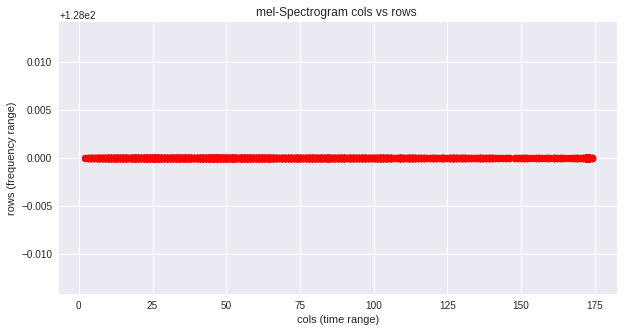

In [24]:
plt.figure(figsize=(10,5))
spectrogram_frequency_size = sound_data['shape'].map(lambda x: x[0])
spectrogram_time_size = sound_data['shape'].map(lambda x: x[1])
plt.scatter(spectrogram_time_size,spectrogram_frequency_size,color='red')
plt.title('mel-Spectrogram cols vs rows ')
plt.xlabel('cols (time range)')
plt.ylabel('rows (frequency range)')
plt.show()

In [5]:
# generate original images in API_images -> use index as unique ID for saved-images 
image_path = './Sound_images_indexID'
ppi = 150
hpix = 2
wpix = 2
for index, rows in sound_data.iterrows():
    # get image id
    img_id = index
    img_name = rows['Class']
    # set up the image size
    plt.figure(figsize=(hpix, wpix))
    lirs_plt.specshow(rows['mel_spectrogram'], x_axis='time', y_axis='mel')
    plt.axis('off')
    # save image
    plt.savefig(f'{image_path}/{img_id}.{img_name}.png', dpi=ppi, transpoarent=True, 
                bbox_inches='tight', format='png',pad_inches=0)

In [25]:
# upsample all signal with smaller size
from scipy import signal
def adjust_shape(sig):
    if sig.shape !=(20,173):
        sig = signal.resample(sig, 173, axis=1)
    return sig
    
new_signal = sound_data['mel_spectrogram'].map(adjust_shape)
sound_data.insert(8,'upsampled_mel',new_signal)
sound_data.head()

slice_file_name classID             Class      time     fr  \
0    100032-3-0-0.wav       3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav       2  children_playing         4  22050   
2  100263-2-0-121.wav       2  children_playing         4  22050   
3  100263-2-0-126.wav       2  children_playing         4  22050   
4  100263-2-0-137.wav       2  children_playing         4  22050   

                                               wavdt  \
0  [-0.0034602168, -0.005025549, -0.004653247, -0...   
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...   
2  [-0.0027075084, -0.0030330168, -0.001595565, -...   
3  [0.00014314766, -0.00022372589, -0.0013724423,...   
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...   

                                     mel_spectrogram       shape  \
0  [[-63.852352, -74.8432, -69.11956, -65.66042, ...   (128, 14)   
1  [[-16.04125, -8.101406, -18.57543, -15.345488,...  (128, 173)   
2  [[-38.806866, -12.0104065, -6.697176, -20.0030...  (128, 173)   
3  [[-15.916054, -17.948147, -17.378323, -17.6051...  (128, 173)   
4  [[-10.569414, -4.963707, -38.794804, -13.43965...  (128, 173)   

                                       upsampled_mel  
0  [[-63.852352, -64.64467, -65.56032, -66.57128,...  
1  [[-16.041246, -8.101406, -18.575428, -15.34548...  
2  [[-38.80687, -12.010411, -6.6971803, -20.00301...  
3  [[-15.916049, -17.948143, -17.37832, -17.60518...  
4  [[-10.56941, -4.96371, -38.794804, -13.439654,...

In [26]:
sound_data.insert(9,'new_shape',sound_data['upsampled_mel'].map(lambda x: x.shape))
sound_data.head()

slice_file_name classID             Class      time     fr  \
0    100032-3-0-0.wav       3          dog_bark  0.317551  22050   
1  100263-2-0-117.wav       2  children_playing         4  22050   
2  100263-2-0-121.wav       2  children_playing         4  22050   
3  100263-2-0-126.wav       2  children_playing         4  22050   
4  100263-2-0-137.wav       2  children_playing         4  22050   

                                               wavdt  \
0  [-0.0034602168, -0.005025549, -0.004653247, -0...   
1  [0.002732961, 0.0036436305, 0.0023043123, 0.00...   
2  [-0.0027075084, -0.0030330168, -0.001595565, -...   
3  [0.00014314766, -0.00022372589, -0.0013724423,...   
4  [0.0012484171, 0.0042897766, 0.006238948, 0.00...   

                                     mel_spectrogram       shape  \
0  [[-63.852352, -74.8432, -69.11956, -65.66042, ...   (128, 14)   
1  [[-16.04125, -8.101406, -18.57543, -15.345488,...  (128, 173)   
2  [[-38.806866, -12.0104065, -6.697176, -20.0030...  (128, 173)   
3  [[-15.916054, -17.948147, -17.378323, -17.6051...  (128, 173)   
4  [[-10.569414, -4.963707, -38.794804, -13.43965...  (128, 173)   

                                       upsampled_mel   new_shape  
0  [[-63.852352, -64.64467, -65.56032, -66.57128,...  (128, 173)  
1  [[-16.041246, -8.101406, -18.575428, -15.34548...  (128, 173)  
2  [[-38.80687, -12.010411, -6.6971803, -20.00301...  (128, 173)  
3  [[-15.916049, -17.948143, -17.37832, -17.60518...  (128, 173)  
4  [[-10.56941, -4.96371, -38.794804, -13.439654,...  (128, 173)

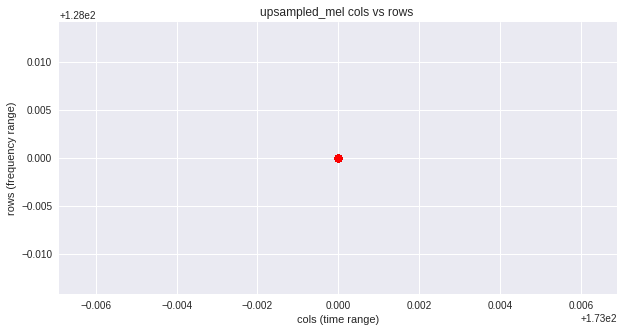

In [27]:
plt.figure(figsize=(10,5))
spectrogram_frequency_size = sound_data['new_shape'].map(lambda x: x[0])
spectrogram_time_size = sound_data['new_shape'].map(lambda x: x[1])
plt.scatter(spectrogram_time_size,spectrogram_frequency_size,color='red')
plt.title('upsampled_mel cols vs rows ')
plt.xlabel('cols (time range)')
plt.ylabel('rows (frequency range)')
plt.show()

In [28]:
sound_data = sound_data.drop(['slice_file_name','time','fr','wavdt','mel_spectrogram','shape','new_shape'], axis=1)
sound_data.head()

classID             Class                                      upsampled_mel
0       3          dog_bark  [[-63.852352, -64.64467, -65.56032, -66.57128,...
1       2  children_playing  [[-16.041246, -8.101406, -18.575428, -15.34548...
2       2  children_playing  [[-38.80687, -12.010411, -6.6971803, -20.00301...
3       2  children_playing  [[-15.916049, -17.948143, -17.37832, -17.60518...
4       2  children_playing  [[-10.56941, -4.96371, -38.794804, -13.439654,...

In [29]:
sound_data.sort_index(axis=0)

classID             Class  \
0          3          dog_bark   
1          2  children_playing   
2          2  children_playing   
3          2  children_playing   
4          2  children_playing   
...      ...               ...   
9933       1          car_horn   
9934       1          car_horn   
9935       1          car_horn   
9936       1          car_horn   
9937       1          car_horn   

                                          upsampled_mel  
0     [[-63.852352, -64.64467, -65.56032, -66.57128,...  
1     [[-16.041246, -8.101406, -18.575428, -15.34548...  
2     [[-38.80687, -12.010411, -6.6971803, -20.00301...  
3     [[-15.916049, -17.948143, -17.37832, -17.60518...  
4     [[-10.56941, -4.96371, -38.794804, -13.439654,...  
...                                                 ...  
9933  [[-32.716866, -22.965027, -26.621183, -16.5024...  
9934  [[-23.711725, -23.182426, -23.387297, -22.3103...  
9935  [[-16.510666, -17.571312, -18.365557, -16.9452...  
9936  [[-12.736515, -19.995268, -21.142107, -14.5016...  
9937  [[-13.760012, -21.594585, -17.962595, -13.1553...  

[9938 rows x 3 columns]

In [30]:
'''
- save sound data
'''
with open('./sound_dataframe_balanced_updated','wb') as f:
    pickle.dump(sound_data,f)

In [6]:
# group the dataset by 'Class' and extract spectrum dataset
spectrum_info=sound_data.groupby('Class').first()[['upsampled_mel']]
spectrum_info

upsampled_mel
Class                                                              
air_conditioner   [[-79.999985, -79.999985, -24.108122, -19.8417...
car_horn          [[-80.0, -78.82176, -74.53251, -67.80022, -59....
children_playing  [[-16.041246, -8.101406, -18.575428, -15.34548...
dog_bark          [[-63.852352, -64.64467, -65.56032, -66.57128,...
drilling          [[-79.999985, -80.0, -58.793655, -60.128624, -...
engine_idling     [[-10.221168, -5.5721273, -6.7693563, -13.9959...
gun_shot          [[-19.596455, -0.60540175, -7.459183, -5.50084...
jackhammer        [[-19.25069, -22.540127, -23.015863, -14.98349...
siren             [[-33.494545, -33.03445, -50.32794, -30.012373...
street_music      [[-27.902363, -39.175587, -35.28071, -34.39931...

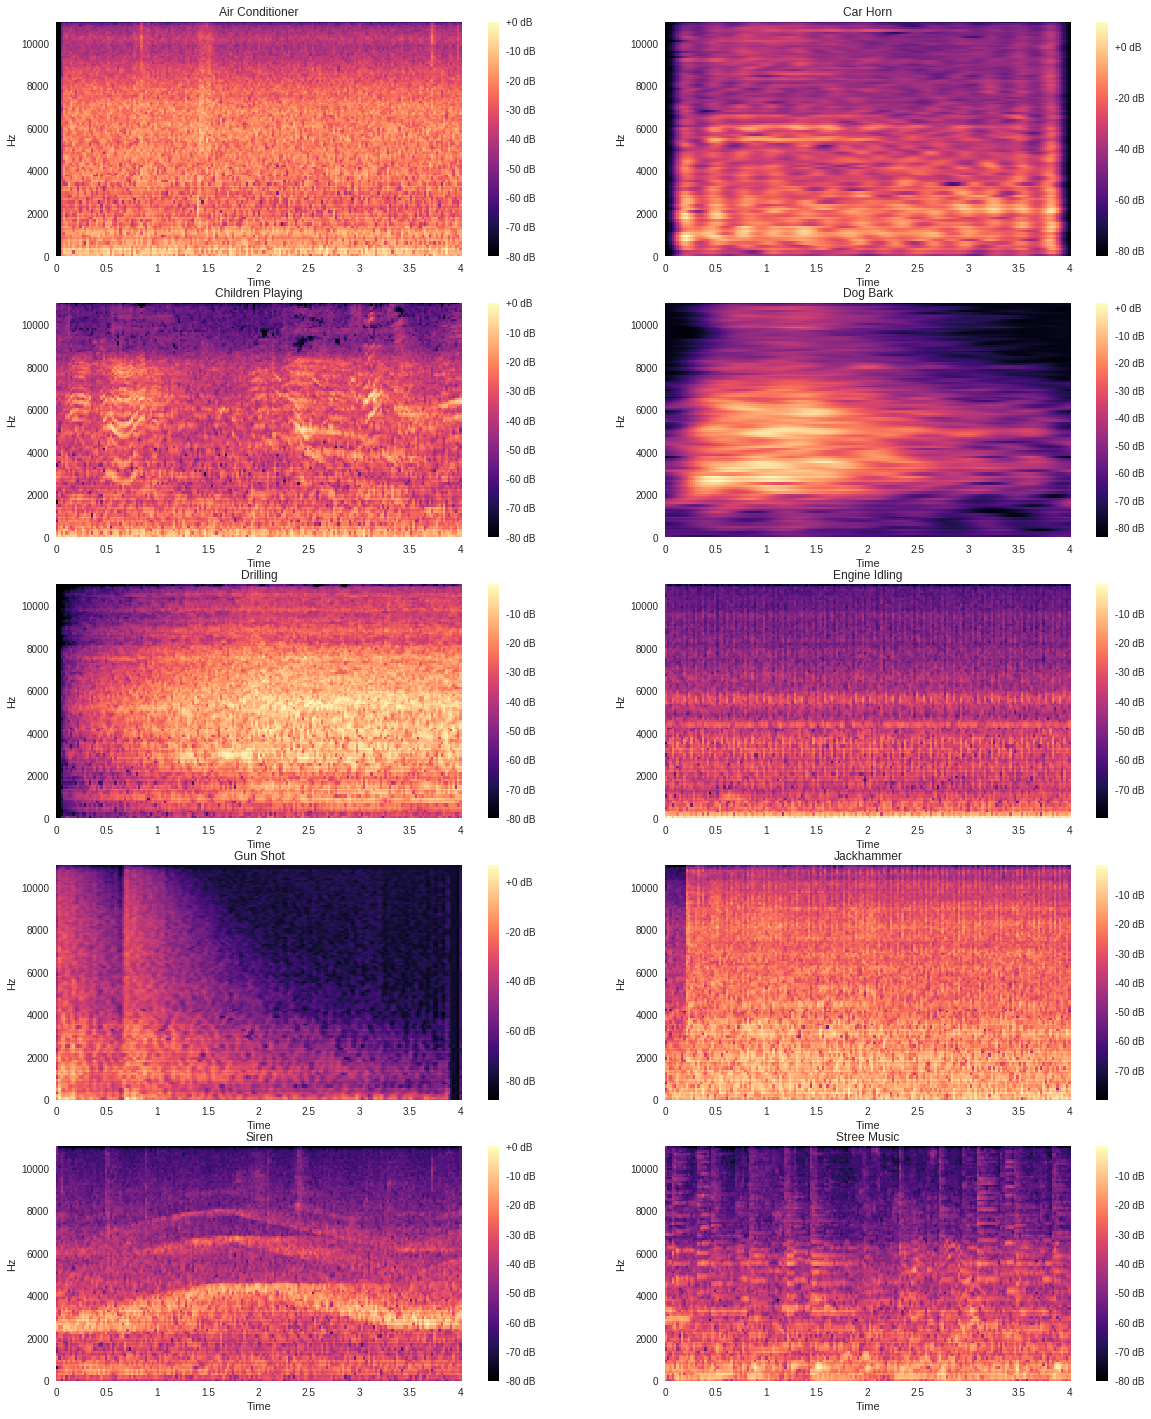

In [7]:
# plot mel-spectrgram for 10-class sound data
plt.figure(figsize=(20,25))
plt.subplot(5,2,1)
lirs_plt.specshow(spectrum_info['upsampled_mel']['air_conditioner'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Air Conditioner')
plt.subplot(5,2,2)
lirs_plt.specshow(spectrum_info['upsampled_mel']['car_horn'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Car Horn')
plt.subplot(5,2,3)
lirs_plt.specshow(spectrum_info['upsampled_mel']['children_playing'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Children Playing')
plt.subplot(5,2,4)
lirs_plt.specshow(spectrum_info['upsampled_mel']['dog_bark'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Dog Bark')
plt.subplot(5,2,5)
lirs_plt.specshow(spectrum_info['upsampled_mel']['drilling'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Drilling')
plt.subplot(5,2,6)
lirs_plt.specshow(spectrum_info['upsampled_mel']['engine_idling'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Engine Idling')
plt.subplot(5,2,7)
lirs_plt.specshow(spectrum_info['upsampled_mel']['gun_shot'], x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Gun Shot')
plt.subplot(5,2,8)
lirs_plt.specshow(spectrum_info['upsampled_mel']['jackhammer'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Jackhammer')
plt.subplot(5,2,9)
lirs_plt.specshow(spectrum_info['upsampled_mel']['siren'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Siren')
plt.subplot(5,2,10)
lirs_plt.specshow(spectrum_info['upsampled_mel']['street_music'],x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Stree Music')
plt.show()

# Generate sound image tensor in the dataframe

In [31]:
'''
- load sound dataframe data
'''
with open('./sound_dataframe_balanced_updated','rb') as f:
    sound_data = pickle.load(f)

sound_data.head()

classID             Class                                      upsampled_mel
0       3          dog_bark  [[-63.852352, -64.64467, -65.56032, -66.57128,...
1       2  children_playing  [[-16.041246, -8.101406, -18.575428, -15.34548...
2       2  children_playing  [[-38.80687, -12.010411, -6.6971803, -20.00301...
3       2  children_playing  [[-15.916049, -17.948143, -17.37832, -17.60518...
4       2  children_playing  [[-10.56941, -4.96371, -38.794804, -13.439654,...

In [7]:
sound_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   classID        9938 non-null   object
 1   Class          9938 non-null   object
 2   upsampled_mel  9938 non-null   object
dtypes: object(3)
memory usage: 233.0+ KB


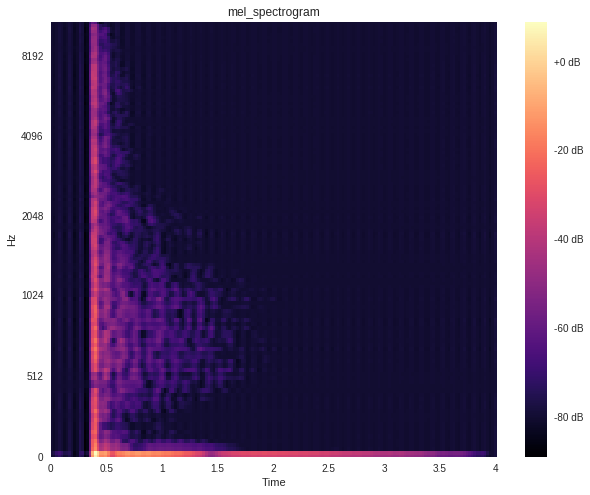

In [36]:
# plot one sound image
plt.figure(figsize=(10,8))
lirs_plt.specshow(sound_data['upsampled_mel'][5102], x_axis='time', y_axis='mel');
plt.title('mel_spectrogram')
plt.colorbar(format='%+2.0f dB');

In [37]:
# !!!!gnenerate img tensors
path = './Sound_images_indexID'
img_tensor_lst= []
img_list = os.listdir(f'{path}/')
for i, row in sound_data.iterrows():
    id_sd = i
    id_name = row['Class']
    for nm in img_list:
        if nm.replace('.png','')==f"{id_sd}.{id_name}":
            print(f'{id_sd},{nm},Done...')
            img_path = f'{path}/{nm}'
            img = image.load_img(img_path, target_size=(200,200))
            img_tensor = image.img_to_array(img)
            img_tensor_lst.append(img_tensor)
            break

0,0.dog_bark.png,Done...
1,1.children_playing.png,Done...
2,2.children_playing.png,Done...
3,3.children_playing.png,Done...
4,4.children_playing.png,Done...
5,5.children_playing.png,Done...
6,6.children_playing.png,Done...
7,7.children_playing.png,Done...
8,8.children_playing.png,Done...
9,9.car_horn.png,Done...
10,10.car_horn.png,Done...
11,11.car_horn.png,Done...
12,12.car_horn.png,Done...
13,13.car_horn.png,Done...
14,14.dog_bark.png,Done...
15,15.dog_bark.png,Done...
16,16.dog_bark.png,Done...
17,17.dog_bark.png,Done...
18,18.dog_bark.png,Done...
19,19.dog_bark.png,Done...
20,20.dog_bark.png,Done...
21,21.dog_bark.png,Done...
22,22.air_conditioner.png,Done...
23,23.air_conditioner.png,Done...
24,24.air_conditioner.png,Done...
25,25.air_conditioner.png,Done...
26,26.air_conditioner.png,Done...
27,27.air_conditioner.png,Done...
28,28.air_conditioner.png,Done...
29,29.air_conditioner.png,Done...
30,30.air_conditioner.png,Done...
31,31.air_conditioner.png,Done...
32,32.air_conditioner.

272,272.children_playing.png,Done...
273,273.children_playing.png,Done...
274,274.children_playing.png,Done...
275,275.children_playing.png,Done...
276,276.children_playing.png,Done...
277,277.children_playing.png,Done...
278,278.drilling.png,Done...
279,279.drilling.png,Done...
280,280.drilling.png,Done...
281,281.drilling.png,Done...
282,282.drilling.png,Done...
283,283.drilling.png,Done...
284,284.drilling.png,Done...
285,285.drilling.png,Done...
286,286.drilling.png,Done...
287,287.drilling.png,Done...
288,288.drilling.png,Done...
289,289.drilling.png,Done...
290,290.drilling.png,Done...
291,291.drilling.png,Done...
292,292.drilling.png,Done...
293,293.drilling.png,Done...
294,294.drilling.png,Done...
295,295.drilling.png,Done...
296,296.drilling.png,Done...
297,297.drilling.png,Done...
298,298.drilling.png,Done...
299,299.drilling.png,Done...
300,300.drilling.png,Done...
301,301.drilling.png,Done...
302,302.drilling.png,Done...
303,303.drilling.png,Done...
304,304.drilling.png,Don

590,590.street_music.png,Done...
591,591.street_music.png,Done...
592,592.children_playing.png,Done...
593,593.children_playing.png,Done...
594,594.children_playing.png,Done...
595,595.children_playing.png,Done...
596,596.children_playing.png,Done...
597,597.children_playing.png,Done...
598,598.children_playing.png,Done...
599,599.dog_bark.png,Done...
600,600.dog_bark.png,Done...
601,601.dog_bark.png,Done...
602,602.dog_bark.png,Done...
603,603.dog_bark.png,Done...
604,604.dog_bark.png,Done...
605,605.dog_bark.png,Done...
606,606.dog_bark.png,Done...
607,607.jackhammer.png,Done...
608,608.jackhammer.png,Done...
609,609.jackhammer.png,Done...
610,610.jackhammer.png,Done...
611,611.gun_shot.png,Done...
612,612.dog_bark.png,Done...
613,613.dog_bark.png,Done...
614,614.dog_bark.png,Done...
615,615.dog_bark.png,Done...
616,616.street_music.png,Done...
617,617.street_music.png,Done...
618,618.street_music.png,Done...
619,619.street_music.png,Done...
620,620.street_music.png,Done...
621,621.s

868,868.car_horn.png,Done...
869,869.street_music.png,Done...
870,870.street_music.png,Done...
871,871.street_music.png,Done...
872,872.street_music.png,Done...
873,873.street_music.png,Done...
874,874.street_music.png,Done...
875,875.car_horn.png,Done...
876,876.dog_bark.png,Done...
877,877.dog_bark.png,Done...
878,878.dog_bark.png,Done...
879,879.dog_bark.png,Done...
880,880.dog_bark.png,Done...
881,881.drilling.png,Done...
882,882.drilling.png,Done...
883,883.drilling.png,Done...
884,884.drilling.png,Done...
885,885.drilling.png,Done...
886,886.drilling.png,Done...
887,887.drilling.png,Done...
888,888.drilling.png,Done...
889,889.drilling.png,Done...
890,890.drilling.png,Done...
891,891.drilling.png,Done...
892,892.drilling.png,Done...
893,893.drilling.png,Done...
894,894.drilling.png,Done...
895,895.siren.png,Done...
896,896.siren.png,Done...
897,897.siren.png,Done...
898,898.siren.png,Done...
899,899.siren.png,Done...
900,900.siren.png,Done...
901,901.siren.png,Done...
902,902.sir

1139,1139.street_music.png,Done...
1140,1140.street_music.png,Done...
1141,1141.street_music.png,Done...
1142,1142.street_music.png,Done...
1143,1143.street_music.png,Done...
1144,1144.street_music.png,Done...
1145,1145.dog_bark.png,Done...
1146,1146.dog_bark.png,Done...
1147,1147.dog_bark.png,Done...
1148,1148.dog_bark.png,Done...
1149,1149.dog_bark.png,Done...
1150,1150.dog_bark.png,Done...
1151,1151.dog_bark.png,Done...
1152,1152.dog_bark.png,Done...
1153,1153.drilling.png,Done...
1154,1154.drilling.png,Done...
1155,1155.drilling.png,Done...
1156,1156.drilling.png,Done...
1157,1157.drilling.png,Done...
1158,1158.drilling.png,Done...
1159,1159.drilling.png,Done...
1160,1160.drilling.png,Done...
1161,1161.drilling.png,Done...
1162,1162.drilling.png,Done...
1163,1163.drilling.png,Done...
1164,1164.drilling.png,Done...
1165,1165.drilling.png,Done...
1166,1166.drilling.png,Done...
1167,1167.drilling.png,Done...
1168,1168.drilling.png,Done...
1169,1169.air_conditioner.png,Done...
1170,117

1401,1401.air_conditioner.png,Done...
1402,1402.air_conditioner.png,Done...
1403,1403.air_conditioner.png,Done...
1404,1404.air_conditioner.png,Done...
1405,1405.air_conditioner.png,Done...
1406,1406.air_conditioner.png,Done...
1407,1407.air_conditioner.png,Done...
1408,1408.siren.png,Done...
1409,1409.siren.png,Done...
1410,1410.siren.png,Done...
1411,1411.siren.png,Done...
1412,1412.siren.png,Done...
1413,1413.siren.png,Done...
1414,1414.siren.png,Done...
1415,1415.siren.png,Done...
1416,1416.siren.png,Done...
1417,1417.siren.png,Done...
1418,1418.siren.png,Done...
1419,1419.siren.png,Done...
1420,1420.gun_shot.png,Done...
1421,1421.gun_shot.png,Done...
1422,1422.gun_shot.png,Done...
1423,1423.gun_shot.png,Done...
1424,1424.gun_shot.png,Done...
1425,1425.gun_shot.png,Done...
1426,1426.gun_shot.png,Done...
1427,1427.gun_shot.png,Done...
1428,1428.gun_shot.png,Done...
1429,1429.gun_shot.png,Done...
1430,1430.gun_shot.png,Done...
1431,1431.gun_shot.png,Done...
1432,1432.gun_shot.png,Don

1666,1666.street_music.png,Done...
1667,1667.street_music.png,Done...
1668,1668.street_music.png,Done...
1669,1669.street_music.png,Done...
1670,1670.street_music.png,Done...
1671,1671.street_music.png,Done...
1672,1672.street_music.png,Done...
1673,1673.street_music.png,Done...
1674,1674.engine_idling.png,Done...
1675,1675.engine_idling.png,Done...
1676,1676.engine_idling.png,Done...
1677,1677.engine_idling.png,Done...
1678,1678.engine_idling.png,Done...
1679,1679.engine_idling.png,Done...
1680,1680.engine_idling.png,Done...
1681,1681.engine_idling.png,Done...
1682,1682.engine_idling.png,Done...
1683,1683.engine_idling.png,Done...
1684,1684.engine_idling.png,Done...
1685,1685.engine_idling.png,Done...
1686,1686.engine_idling.png,Done...
1687,1687.engine_idling.png,Done...
1688,1688.engine_idling.png,Done...
1689,1689.engine_idling.png,Done...
1690,1690.engine_idling.png,Done...
1691,1691.engine_idling.png,Done...
1692,1692.engine_idling.png,Done...
1693,1693.engine_idling.png,Done...


1922,1922.air_conditioner.png,Done...
1923,1923.air_conditioner.png,Done...
1924,1924.air_conditioner.png,Done...
1925,1925.air_conditioner.png,Done...
1926,1926.air_conditioner.png,Done...
1927,1927.air_conditioner.png,Done...
1928,1928.air_conditioner.png,Done...
1929,1929.air_conditioner.png,Done...
1930,1930.air_conditioner.png,Done...
1931,1931.air_conditioner.png,Done...
1932,1932.air_conditioner.png,Done...
1933,1933.air_conditioner.png,Done...
1934,1934.air_conditioner.png,Done...
1935,1935.air_conditioner.png,Done...
1936,1936.air_conditioner.png,Done...
1937,1937.air_conditioner.png,Done...
1938,1938.air_conditioner.png,Done...
1939,1939.air_conditioner.png,Done...
1940,1940.air_conditioner.png,Done...
1941,1941.air_conditioner.png,Done...
1942,1942.air_conditioner.png,Done...
1943,1943.air_conditioner.png,Done...
1944,1944.air_conditioner.png,Done...
1945,1945.air_conditioner.png,Done...
1946,1946.air_conditioner.png,Done...
1947,1947.drilling.png,Done...
1948,1948.gun_shot.

2188,2188.engine_idling.png,Done...
2189,2189.engine_idling.png,Done...
2190,2190.engine_idling.png,Done...
2191,2191.engine_idling.png,Done...
2192,2192.engine_idling.png,Done...
2193,2193.engine_idling.png,Done...
2194,2194.engine_idling.png,Done...
2195,2195.engine_idling.png,Done...
2196,2196.street_music.png,Done...
2197,2197.street_music.png,Done...
2198,2198.street_music.png,Done...
2199,2199.street_music.png,Done...
2200,2200.street_music.png,Done...
2201,2201.street_music.png,Done...
2202,2202.street_music.png,Done...
2203,2203.street_music.png,Done...
2204,2204.street_music.png,Done...
2205,2205.street_music.png,Done...
2206,2206.street_music.png,Done...
2207,2207.street_music.png,Done...
2208,2208.car_horn.png,Done...
2209,2209.car_horn.png,Done...
2210,2210.car_horn.png,Done...
2211,2211.car_horn.png,Done...
2212,2212.car_horn.png,Done...
2213,2213.street_music.png,Done...
2214,2214.street_music.png,Done...
2215,2215.street_music.png,Done...
2216,2216.street_music.png,Done.

2459,2459.siren.png,Done...
2460,2460.siren.png,Done...
2461,2461.siren.png,Done...
2462,2462.siren.png,Done...
2463,2463.siren.png,Done...
2464,2464.siren.png,Done...
2465,2465.siren.png,Done...
2466,2466.siren.png,Done...
2467,2467.siren.png,Done...
2468,2468.siren.png,Done...
2469,2469.siren.png,Done...
2470,2470.siren.png,Done...
2471,2471.siren.png,Done...
2472,2472.siren.png,Done...
2473,2473.siren.png,Done...
2474,2474.siren.png,Done...
2475,2475.siren.png,Done...
2476,2476.siren.png,Done...
2477,2477.siren.png,Done...
2478,2478.siren.png,Done...
2479,2479.siren.png,Done...
2480,2480.siren.png,Done...
2481,2481.siren.png,Done...
2482,2482.siren.png,Done...
2483,2483.siren.png,Done...
2484,2484.siren.png,Done...
2485,2485.siren.png,Done...
2486,2486.siren.png,Done...
2487,2487.siren.png,Done...
2488,2488.siren.png,Done...
2489,2489.siren.png,Done...
2490,2490.siren.png,Done...
2491,2491.siren.png,Done...
2492,2492.siren.png,Done...
2493,2493.siren.png,Done...
2494,2494.siren.png,

2786,2786.siren.png,Done...
2787,2787.air_conditioner.png,Done...
2788,2788.air_conditioner.png,Done...
2789,2789.air_conditioner.png,Done...
2790,2790.air_conditioner.png,Done...
2791,2791.air_conditioner.png,Done...
2792,2792.air_conditioner.png,Done...
2793,2793.air_conditioner.png,Done...
2794,2794.air_conditioner.png,Done...
2795,2795.air_conditioner.png,Done...
2796,2796.children_playing.png,Done...
2797,2797.children_playing.png,Done...
2798,2798.children_playing.png,Done...
2799,2799.children_playing.png,Done...
2800,2800.children_playing.png,Done...
2801,2801.children_playing.png,Done...
2802,2802.children_playing.png,Done...
2803,2803.children_playing.png,Done...
2804,2804.children_playing.png,Done...
2805,2805.children_playing.png,Done...
2806,2806.children_playing.png,Done...
2807,2807.children_playing.png,Done...
2808,2808.children_playing.png,Done...
2809,2809.children_playing.png,Done...
2810,2810.children_playing.png,Done...
2811,2811.children_playing.png,Done...
2812,2

3053,3053.car_horn.png,Done...
3054,3054.car_horn.png,Done...
3055,3055.gun_shot.png,Done...
3056,3056.gun_shot.png,Done...
3057,3057.siren.png,Done...
3058,3058.siren.png,Done...
3059,3059.siren.png,Done...
3060,3060.siren.png,Done...
3061,3061.siren.png,Done...
3062,3062.siren.png,Done...
3063,3063.siren.png,Done...
3064,3064.siren.png,Done...
3065,3065.children_playing.png,Done...
3066,3066.children_playing.png,Done...
3067,3067.children_playing.png,Done...
3068,3068.children_playing.png,Done...
3069,3069.children_playing.png,Done...
3070,3070.children_playing.png,Done...
3071,3071.children_playing.png,Done...
3072,3072.jackhammer.png,Done...
3073,3073.jackhammer.png,Done...
3074,3074.jackhammer.png,Done...
3075,3075.jackhammer.png,Done...
3076,3076.jackhammer.png,Done...
3077,3077.jackhammer.png,Done...
3078,3078.jackhammer.png,Done...
3079,3079.jackhammer.png,Done...
3080,3080.jackhammer.png,Done...
3081,3081.jackhammer.png,Done...
3082,3082.jackhammer.png,Done...
3083,3083.jackha

3302,3302.drilling.png,Done...
3303,3303.drilling.png,Done...
3304,3304.drilling.png,Done...
3305,3305.drilling.png,Done...
3306,3306.drilling.png,Done...
3307,3307.drilling.png,Done...
3308,3308.drilling.png,Done...
3309,3309.drilling.png,Done...
3310,3310.drilling.png,Done...
3311,3311.drilling.png,Done...
3312,3312.drilling.png,Done...
3313,3313.drilling.png,Done...
3314,3314.drilling.png,Done...
3315,3315.street_music.png,Done...
3316,3316.street_music.png,Done...
3317,3317.street_music.png,Done...
3318,3318.street_music.png,Done...
3319,3319.street_music.png,Done...
3320,3320.street_music.png,Done...
3321,3321.street_music.png,Done...
3322,3322.street_music.png,Done...
3323,3323.street_music.png,Done...
3324,3324.street_music.png,Done...
3325,3325.street_music.png,Done...
3326,3326.street_music.png,Done...
3327,3327.engine_idling.png,Done...
3328,3328.engine_idling.png,Done...
3329,3329.engine_idling.png,Done...
3330,3330.engine_idling.png,Done...
3331,3331.engine_idling.png,Done.

3551,3551.children_playing.png,Done...
3552,3552.children_playing.png,Done...
3553,3553.children_playing.png,Done...
3554,3554.children_playing.png,Done...
3555,3555.car_horn.png,Done...
3556,3556.street_music.png,Done...
3557,3557.street_music.png,Done...
3558,3558.street_music.png,Done...
3559,3559.street_music.png,Done...
3560,3560.street_music.png,Done...
3561,3561.street_music.png,Done...
3562,3562.dog_bark.png,Done...
3563,3563.dog_bark.png,Done...
3564,3564.dog_bark.png,Done...
3565,3565.dog_bark.png,Done...
3566,3566.dog_bark.png,Done...
3567,3567.dog_bark.png,Done...
3568,3568.dog_bark.png,Done...
3569,3569.dog_bark.png,Done...
3570,3570.dog_bark.png,Done...
3571,3571.dog_bark.png,Done...
3572,3572.dog_bark.png,Done...
3573,3573.dog_bark.png,Done...
3574,3574.dog_bark.png,Done...
3575,3575.dog_bark.png,Done...
3576,3576.dog_bark.png,Done...
3577,3577.dog_bark.png,Done...
3578,3578.children_playing.png,Done...
3579,3579.children_playing.png,Done...
3580,3580.children_playing.pn

3830,3830.jackhammer.png,Done...
3831,3831.jackhammer.png,Done...
3832,3832.jackhammer.png,Done...
3833,3833.jackhammer.png,Done...
3834,3834.jackhammer.png,Done...
3835,3835.jackhammer.png,Done...
3836,3836.jackhammer.png,Done...
3837,3837.jackhammer.png,Done...
3838,3838.jackhammer.png,Done...
3839,3839.jackhammer.png,Done...
3840,3840.jackhammer.png,Done...
3841,3841.jackhammer.png,Done...
3842,3842.engine_idling.png,Done...
3843,3843.engine_idling.png,Done...
3844,3844.engine_idling.png,Done...
3845,3845.engine_idling.png,Done...
3846,3846.engine_idling.png,Done...
3847,3847.engine_idling.png,Done...
3848,3848.engine_idling.png,Done...
3849,3849.engine_idling.png,Done...
3850,3850.engine_idling.png,Done...
3851,3851.engine_idling.png,Done...
3852,3852.engine_idling.png,Done...
3853,3853.dog_bark.png,Done...
3854,3854.dog_bark.png,Done...
3855,3855.dog_bark.png,Done...
3856,3856.dog_bark.png,Done...
3857,3857.air_conditioner.png,Done...
3858,3858.air_conditioner.png,Done...
3859,385

4107,4107.children_playing.png,Done...
4108,4108.children_playing.png,Done...
4109,4109.children_playing.png,Done...
4110,4110.children_playing.png,Done...
4111,4111.children_playing.png,Done...
4112,4112.children_playing.png,Done...
4113,4113.children_playing.png,Done...
4114,4114.children_playing.png,Done...
4115,4115.children_playing.png,Done...
4116,4116.children_playing.png,Done...
4117,4117.children_playing.png,Done...
4118,4118.children_playing.png,Done...
4119,4119.children_playing.png,Done...
4120,4120.children_playing.png,Done...
4121,4121.children_playing.png,Done...
4122,4122.street_music.png,Done...
4123,4123.street_music.png,Done...
4124,4124.street_music.png,Done...
4125,4125.street_music.png,Done...
4126,4126.street_music.png,Done...
4127,4127.street_music.png,Done...
4128,4128.dog_bark.png,Done...
4129,4129.dog_bark.png,Done...
4130,4130.dog_bark.png,Done...
4131,4131.dog_bark.png,Done...
4132,4132.drilling.png,Done...
4133,4133.drilling.png,Done...
4134,4134.drilling.

4373,4373.jackhammer.png,Done...
4374,4374.jackhammer.png,Done...
4375,4375.jackhammer.png,Done...
4376,4376.jackhammer.png,Done...
4377,4377.jackhammer.png,Done...
4378,4378.jackhammer.png,Done...
4379,4379.jackhammer.png,Done...
4380,4380.jackhammer.png,Done...
4381,4381.jackhammer.png,Done...
4382,4382.jackhammer.png,Done...
4383,4383.jackhammer.png,Done...
4384,4384.jackhammer.png,Done...
4385,4385.jackhammer.png,Done...
4386,4386.jackhammer.png,Done...
4387,4387.jackhammer.png,Done...
4388,4388.jackhammer.png,Done...
4389,4389.jackhammer.png,Done...
4390,4390.jackhammer.png,Done...
4391,4391.jackhammer.png,Done...
4392,4392.jackhammer.png,Done...
4393,4393.jackhammer.png,Done...
4394,4394.gun_shot.png,Done...
4395,4395.dog_bark.png,Done...
4396,4396.dog_bark.png,Done...
4397,4397.dog_bark.png,Done...
4398,4398.street_music.png,Done...
4399,4399.street_music.png,Done...
4400,4400.street_music.png,Done...
4401,4401.street_music.png,Done...
4402,4402.street_music.png,Done...
4403,440

4647,4647.siren.png,Done...
4648,4648.children_playing.png,Done...
4649,4649.children_playing.png,Done...
4650,4650.children_playing.png,Done...
4651,4651.children_playing.png,Done...
4652,4652.children_playing.png,Done...
4653,4653.children_playing.png,Done...
4654,4654.children_playing.png,Done...
4655,4655.children_playing.png,Done...
4656,4656.jackhammer.png,Done...
4657,4657.jackhammer.png,Done...
4658,4658.jackhammer.png,Done...
4659,4659.jackhammer.png,Done...
4660,4660.jackhammer.png,Done...
4661,4661.jackhammer.png,Done...
4662,4662.jackhammer.png,Done...
4663,4663.jackhammer.png,Done...
4664,4664.jackhammer.png,Done...
4665,4665.jackhammer.png,Done...
4666,4666.jackhammer.png,Done...
4667,4667.jackhammer.png,Done...
4668,4668.jackhammer.png,Done...
4669,4669.jackhammer.png,Done...
4670,4670.jackhammer.png,Done...
4671,4671.jackhammer.png,Done...
4672,4672.jackhammer.png,Done...
4673,4673.jackhammer.png,Done...
4674,4674.jackhammer.png,Done...
4675,4675.jackhammer.png,Done...


4922,4922.street_music.png,Done...
4923,4923.street_music.png,Done...
4924,4924.street_music.png,Done...
4925,4925.street_music.png,Done...
4926,4926.street_music.png,Done...
4927,4927.street_music.png,Done...
4928,4928.street_music.png,Done...
4929,4929.street_music.png,Done...
4930,4930.street_music.png,Done...
4931,4931.street_music.png,Done...
4932,4932.street_music.png,Done...
4933,4933.street_music.png,Done...
4934,4934.street_music.png,Done...
4935,4935.street_music.png,Done...
4936,4936.street_music.png,Done...
4937,4937.street_music.png,Done...
4938,4938.street_music.png,Done...
4939,4939.street_music.png,Done...
4940,4940.street_music.png,Done...
4941,4941.dog_bark.png,Done...
4942,4942.dog_bark.png,Done...
4943,4943.dog_bark.png,Done...
4944,4944.dog_bark.png,Done...
4945,4945.dog_bark.png,Done...
4946,4946.dog_bark.png,Done...
4947,4947.dog_bark.png,Done...
4948,4948.street_music.png,Done...
4949,4949.street_music.png,Done...
4950,4950.street_music.png,Done...
4951,4951.str

5165,5165.gun_shot.png,Done...
5166,5166.gun_shot.png,Done...
5167,5167.gun_shot.png,Done...
5168,5168.gun_shot.png,Done...
5169,5169.gun_shot.png,Done...
5170,5170.engine_idling.png,Done...
5171,5171.engine_idling.png,Done...
5172,5172.engine_idling.png,Done...
5173,5173.engine_idling.png,Done...
5174,5174.engine_idling.png,Done...
5175,5175.engine_idling.png,Done...
5176,5176.engine_idling.png,Done...
5177,5177.dog_bark.png,Done...
5178,5178.dog_bark.png,Done...
5179,5179.dog_bark.png,Done...
5180,5180.dog_bark.png,Done...
5181,5181.engine_idling.png,Done...
5182,5182.engine_idling.png,Done...
5183,5183.engine_idling.png,Done...
5184,5184.engine_idling.png,Done...
5185,5185.engine_idling.png,Done...
5186,5186.engine_idling.png,Done...
5187,5187.engine_idling.png,Done...
5188,5188.engine_idling.png,Done...
5189,5189.engine_idling.png,Done...
5190,5190.engine_idling.png,Done...
5191,5191.engine_idling.png,Done...
5192,5192.engine_idling.png,Done...
5193,5193.engine_idling.png,Done...
5

5408,5408.air_conditioner.png,Done...
5409,5409.air_conditioner.png,Done...
5410,5410.air_conditioner.png,Done...
5411,5411.air_conditioner.png,Done...
5412,5412.air_conditioner.png,Done...
5413,5413.air_conditioner.png,Done...
5414,5414.air_conditioner.png,Done...
5415,5415.air_conditioner.png,Done...
5416,5416.air_conditioner.png,Done...
5417,5417.air_conditioner.png,Done...
5418,5418.air_conditioner.png,Done...
5419,5419.air_conditioner.png,Done...
5420,5420.air_conditioner.png,Done...
5421,5421.air_conditioner.png,Done...
5422,5422.air_conditioner.png,Done...
5423,5423.children_playing.png,Done...
5424,5424.children_playing.png,Done...
5425,5425.children_playing.png,Done...
5426,5426.children_playing.png,Done...
5427,5427.children_playing.png,Done...
5428,5428.children_playing.png,Done...
5429,5429.children_playing.png,Done...
5430,5430.children_playing.png,Done...
5431,5431.children_playing.png,Done...
5432,5432.children_playing.png,Done...
5433,5433.children_playing.png,Done...
5

5654,5654.jackhammer.png,Done...
5655,5655.jackhammer.png,Done...
5656,5656.jackhammer.png,Done...
5657,5657.jackhammer.png,Done...
5658,5658.jackhammer.png,Done...
5659,5659.jackhammer.png,Done...
5660,5660.jackhammer.png,Done...
5661,5661.jackhammer.png,Done...
5662,5662.jackhammer.png,Done...
5663,5663.jackhammer.png,Done...
5664,5664.jackhammer.png,Done...
5665,5665.jackhammer.png,Done...
5666,5666.jackhammer.png,Done...
5667,5667.jackhammer.png,Done...
5668,5668.jackhammer.png,Done...
5669,5669.jackhammer.png,Done...
5670,5670.jackhammer.png,Done...
5671,5671.jackhammer.png,Done...
5672,5672.jackhammer.png,Done...
5673,5673.jackhammer.png,Done...
5674,5674.jackhammer.png,Done...
5675,5675.jackhammer.png,Done...
5676,5676.jackhammer.png,Done...
5677,5677.jackhammer.png,Done...
5678,5678.jackhammer.png,Done...
5679,5679.jackhammer.png,Done...
5680,5680.jackhammer.png,Done...
5681,5681.jackhammer.png,Done...
5682,5682.jackhammer.png,Done...
5683,5683.jackhammer.png,Done...
5684,5684.

5964,5964.car_horn.png,Done...
5965,5965.drilling.png,Done...
5966,5966.drilling.png,Done...
5967,5967.drilling.png,Done...
5968,5968.drilling.png,Done...
5969,5969.drilling.png,Done...
5970,5970.drilling.png,Done...
5971,5971.drilling.png,Done...
5972,5972.drilling.png,Done...
5973,5973.drilling.png,Done...
5974,5974.drilling.png,Done...
5975,5975.drilling.png,Done...
5976,5976.drilling.png,Done...
5977,5977.drilling.png,Done...
5978,5978.drilling.png,Done...
5979,5979.drilling.png,Done...
5980,5980.drilling.png,Done...
5981,5981.drilling.png,Done...
5982,5982.drilling.png,Done...
5983,5983.drilling.png,Done...
5984,5984.drilling.png,Done...
5985,5985.drilling.png,Done...
5986,5986.drilling.png,Done...
5987,5987.car_horn.png,Done...
5988,5988.car_horn.png,Done...
5989,5989.dog_bark.png,Done...
5990,5990.dog_bark.png,Done...
5991,5991.dog_bark.png,Done...
5992,5992.dog_bark.png,Done...
5993,5993.dog_bark.png,Done...
5994,5994.dog_bark.png,Done...
5995,5995.dog_bark.png,Done...
5996,599

6261,6261.drilling.png,Done...
6262,6262.drilling.png,Done...
6263,6263.dog_bark.png,Done...
6264,6264.dog_bark.png,Done...
6265,6265.dog_bark.png,Done...
6266,6266.dog_bark.png,Done...
6267,6267.dog_bark.png,Done...
6268,6268.dog_bark.png,Done...
6269,6269.dog_bark.png,Done...
6270,6270.dog_bark.png,Done...
6271,6271.dog_bark.png,Done...
6272,6272.dog_bark.png,Done...
6273,6273.dog_bark.png,Done...
6274,6274.dog_bark.png,Done...
6275,6275.drilling.png,Done...
6276,6276.drilling.png,Done...
6277,6277.drilling.png,Done...
6278,6278.drilling.png,Done...
6279,6279.drilling.png,Done...
6280,6280.drilling.png,Done...
6281,6281.engine_idling.png,Done...
6282,6282.engine_idling.png,Done...
6283,6283.engine_idling.png,Done...
6284,6284.engine_idling.png,Done...
6285,6285.engine_idling.png,Done...
6286,6286.engine_idling.png,Done...
6287,6287.engine_idling.png,Done...
6288,6288.engine_idling.png,Done...
6289,6289.engine_idling.png,Done...
6290,6290.engine_idling.png,Done...
6291,6291.engine_idl

6511,6511.gun_shot.png,Done...
6512,6512.gun_shot.png,Done...
6513,6513.drilling.png,Done...
6514,6514.drilling.png,Done...
6515,6515.drilling.png,Done...
6516,6516.drilling.png,Done...
6517,6517.drilling.png,Done...
6518,6518.drilling.png,Done...
6519,6519.drilling.png,Done...
6520,6520.drilling.png,Done...
6521,6521.drilling.png,Done...
6522,6522.drilling.png,Done...
6523,6523.drilling.png,Done...
6524,6524.drilling.png,Done...
6525,6525.drilling.png,Done...
6526,6526.drilling.png,Done...
6527,6527.drilling.png,Done...
6528,6528.drilling.png,Done...
6529,6529.drilling.png,Done...
6530,6530.drilling.png,Done...
6531,6531.drilling.png,Done...
6532,6532.drilling.png,Done...
6533,6533.drilling.png,Done...
6534,6534.drilling.png,Done...
6535,6535.drilling.png,Done...
6536,6536.drilling.png,Done...
6537,6537.drilling.png,Done...
6538,6538.drilling.png,Done...
6539,6539.engine_idling.png,Done...
6540,6540.engine_idling.png,Done...
6541,6541.engine_idling.png,Done...
6542,6542.children_playi

6762,6762.dog_bark.png,Done...
6763,6763.dog_bark.png,Done...
6764,6764.dog_bark.png,Done...
6765,6765.dog_bark.png,Done...
6766,6766.dog_bark.png,Done...
6767,6767.siren.png,Done...
6768,6768.siren.png,Done...
6769,6769.siren.png,Done...
6770,6770.siren.png,Done...
6771,6771.siren.png,Done...
6772,6772.siren.png,Done...
6773,6773.siren.png,Done...
6774,6774.siren.png,Done...
6775,6775.siren.png,Done...
6776,6776.siren.png,Done...
6777,6777.siren.png,Done...
6778,6778.children_playing.png,Done...
6779,6779.children_playing.png,Done...
6780,6780.children_playing.png,Done...
6781,6781.children_playing.png,Done...
6782,6782.children_playing.png,Done...
6783,6783.children_playing.png,Done...
6784,6784.children_playing.png,Done...
6785,6785.drilling.png,Done...
6786,6786.drilling.png,Done...
6787,6787.drilling.png,Done...
6788,6788.drilling.png,Done...
6789,6789.drilling.png,Done...
6790,6790.drilling.png,Done...
6791,6791.drilling.png,Done...
6792,6792.drilling.png,Done...
6793,6793.drilli

7016,7016.children_playing.png,Done...
7017,7017.children_playing.png,Done...
7018,7018.children_playing.png,Done...
7019,7019.children_playing.png,Done...
7020,7020.dog_bark.png,Done...
7021,7021.dog_bark.png,Done...
7022,7022.dog_bark.png,Done...
7023,7023.dog_bark.png,Done...
7024,7024.dog_bark.png,Done...
7025,7025.dog_bark.png,Done...
7026,7026.dog_bark.png,Done...
7027,7027.dog_bark.png,Done...
7028,7028.children_playing.png,Done...
7029,7029.children_playing.png,Done...
7030,7030.children_playing.png,Done...
7031,7031.children_playing.png,Done...
7032,7032.children_playing.png,Done...
7033,7033.children_playing.png,Done...
7034,7034.children_playing.png,Done...
7035,7035.children_playing.png,Done...
7036,7036.street_music.png,Done...
7037,7037.street_music.png,Done...
7038,7038.street_music.png,Done...
7039,7039.street_music.png,Done...
7040,7040.street_music.png,Done...
7041,7041.street_music.png,Done...
7042,7042.street_music.png,Done...
7043,7043.street_music.png,Done...
7044

7274,7274.children_playing.png,Done...
7275,7275.children_playing.png,Done...
7276,7276.children_playing.png,Done...
7277,7277.children_playing.png,Done...
7278,7278.children_playing.png,Done...
7279,7279.children_playing.png,Done...
7280,7280.children_playing.png,Done...
7281,7281.drilling.png,Done...
7282,7282.drilling.png,Done...
7283,7283.drilling.png,Done...
7284,7284.drilling.png,Done...
7285,7285.drilling.png,Done...
7286,7286.drilling.png,Done...
7287,7287.drilling.png,Done...
7288,7288.drilling.png,Done...
7289,7289.drilling.png,Done...
7290,7290.drilling.png,Done...
7291,7291.drilling.png,Done...
7292,7292.drilling.png,Done...
7293,7293.drilling.png,Done...
7294,7294.drilling.png,Done...
7295,7295.drilling.png,Done...
7296,7296.drilling.png,Done...
7297,7297.siren.png,Done...
7298,7298.siren.png,Done...
7299,7299.dog_bark.png,Done...
7300,7300.dog_bark.png,Done...
7301,7301.dog_bark.png,Done...
7302,7302.jackhammer.png,Done...
7303,7303.jackhammer.png,Done...
7304,7304.jackha

7591,7591.car_horn.png,Done...
7592,7592.car_horn.png,Done...
7593,7593.car_horn.png,Done...
7594,7594.car_horn.png,Done...
7595,7595.car_horn.png,Done...
7596,7596.car_horn.png,Done...
7597,7597.car_horn.png,Done...
7598,7598.car_horn.png,Done...
7599,7599.car_horn.png,Done...
7600,7600.car_horn.png,Done...
7601,7601.car_horn.png,Done...
7602,7602.car_horn.png,Done...
7603,7603.car_horn.png,Done...
7604,7604.dog_bark.png,Done...
7605,7605.dog_bark.png,Done...
7606,7606.dog_bark.png,Done...
7607,7607.dog_bark.png,Done...
7608,7608.dog_bark.png,Done...
7609,7609.dog_bark.png,Done...
7610,7610.dog_bark.png,Done...
7611,7611.dog_bark.png,Done...
7612,7612.dog_bark.png,Done...
7613,7613.dog_bark.png,Done...
7614,7614.dog_bark.png,Done...
7615,7615.dog_bark.png,Done...
7616,7616.car_horn.png,Done...
7617,7617.car_horn.png,Done...
7618,7618.car_horn.png,Done...
7619,7619.street_music.png,Done...
7620,7620.street_music.png,Done...
7621,7621.street_music.png,Done...
7622,7622.street_music.png,

7843,7843.street_music.png,Done...
7844,7844.street_music.png,Done...
7845,7845.street_music.png,Done...
7846,7846.street_music.png,Done...
7847,7847.street_music.png,Done...
7848,7848.street_music.png,Done...
7849,7849.street_music.png,Done...
7850,7850.drilling.png,Done...
7851,7851.drilling.png,Done...
7852,7852.drilling.png,Done...
7853,7853.drilling.png,Done...
7854,7854.drilling.png,Done...
7855,7855.drilling.png,Done...
7856,7856.drilling.png,Done...
7857,7857.drilling.png,Done...
7858,7858.dog_bark.png,Done...
7859,7859.dog_bark.png,Done...
7860,7860.dog_bark.png,Done...
7861,7861.drilling.png,Done...
7862,7862.drilling.png,Done...
7863,7863.drilling.png,Done...
7864,7864.drilling.png,Done...
7865,7865.drilling.png,Done...
7866,7866.drilling.png,Done...
7867,7867.drilling.png,Done...
7868,7868.siren.png,Done...
7869,7869.siren.png,Done...
7870,7870.siren.png,Done...
7871,7871.siren.png,Done...
7872,7872.siren.png,Done...
7873,7873.air_conditioner.png,Done...
7874,7874.air_condi

8090,8090.engine_idling.png,Done...
8091,8091.engine_idling.png,Done...
8092,8092.engine_idling.png,Done...
8093,8093.engine_idling.png,Done...
8094,8094.engine_idling.png,Done...
8095,8095.engine_idling.png,Done...
8096,8096.engine_idling.png,Done...
8097,8097.engine_idling.png,Done...
8098,8098.engine_idling.png,Done...
8099,8099.engine_idling.png,Done...
8100,8100.gun_shot.png,Done...
8101,8101.air_conditioner.png,Done...
8102,8102.air_conditioner.png,Done...
8103,8103.air_conditioner.png,Done...
8104,8104.air_conditioner.png,Done...
8105,8105.air_conditioner.png,Done...
8106,8106.air_conditioner.png,Done...
8107,8107.air_conditioner.png,Done...
8108,8108.air_conditioner.png,Done...
8109,8109.air_conditioner.png,Done...
8110,8110.air_conditioner.png,Done...
8111,8111.air_conditioner.png,Done...
8112,8112.air_conditioner.png,Done...
8113,8113.air_conditioner.png,Done...
8114,8114.air_conditioner.png,Done...
8115,8115.air_conditioner.png,Done...
8116,8116.air_conditioner.png,Done...
8

8367,8367.car_horn.png,Done...
8368,8368.car_horn.png,Done...
8369,8369.engine_idling.png,Done...
8370,8370.engine_idling.png,Done...
8371,8371.engine_idling.png,Done...
8372,8372.engine_idling.png,Done...
8373,8373.engine_idling.png,Done...
8374,8374.engine_idling.png,Done...
8375,8375.engine_idling.png,Done...
8376,8376.jackhammer.png,Done...
8377,8377.jackhammer.png,Done...
8378,8378.jackhammer.png,Done...
8379,8379.jackhammer.png,Done...
8380,8380.jackhammer.png,Done...
8381,8381.jackhammer.png,Done...
8382,8382.jackhammer.png,Done...
8383,8383.jackhammer.png,Done...
8384,8384.jackhammer.png,Done...
8385,8385.jackhammer.png,Done...
8386,8386.jackhammer.png,Done...
8387,8387.jackhammer.png,Done...
8388,8388.jackhammer.png,Done...
8389,8389.jackhammer.png,Done...
8390,8390.siren.png,Done...
8391,8391.siren.png,Done...
8392,8392.siren.png,Done...
8393,8393.siren.png,Done...
8394,8394.siren.png,Done...
8395,8395.siren.png,Done...
8396,8396.siren.png,Done...
8397,8397.dog_bark.png,Done.

8657,8657.jackhammer.png,Done...
8658,8658.jackhammer.png,Done...
8659,8659.jackhammer.png,Done...
8660,8660.jackhammer.png,Done...
8661,8661.jackhammer.png,Done...
8662,8662.jackhammer.png,Done...
8663,8663.street_music.png,Done...
8664,8664.street_music.png,Done...
8665,8665.street_music.png,Done...
8666,8666.street_music.png,Done...
8667,8667.street_music.png,Done...
8668,8668.street_music.png,Done...
8669,8669.street_music.png,Done...
8670,8670.street_music.png,Done...
8671,8671.street_music.png,Done...
8672,8672.street_music.png,Done...
8673,8673.street_music.png,Done...
8674,8674.street_music.png,Done...
8675,8675.street_music.png,Done...
8676,8676.street_music.png,Done...
8677,8677.street_music.png,Done...
8678,8678.street_music.png,Done...
8679,8679.street_music.png,Done...
8680,8680.street_music.png,Done...
8681,8681.dog_bark.png,Done...
8682,8682.drilling.png,Done...
8683,8683.drilling.png,Done...
8684,8684.drilling.png,Done...
8685,8685.drilling.png,Done...
8686,8686.drillin

8943,8943.gun_shot.png,Done...
8944,8944.gun_shot.png,Done...
8945,8945.gun_shot.png,Done...
8946,8946.gun_shot.png,Done...
8947,8947.gun_shot.png,Done...
8948,8948.gun_shot.png,Done...
8949,8949.gun_shot.png,Done...
8950,8950.gun_shot.png,Done...
8951,8951.gun_shot.png,Done...
8952,8952.gun_shot.png,Done...
8953,8953.gun_shot.png,Done...
8954,8954.gun_shot.png,Done...
8955,8955.gun_shot.png,Done...
8956,8956.gun_shot.png,Done...
8957,8957.gun_shot.png,Done...
8958,8958.gun_shot.png,Done...
8959,8959.gun_shot.png,Done...
8960,8960.gun_shot.png,Done...
8961,8961.gun_shot.png,Done...
8962,8962.gun_shot.png,Done...
8963,8963.gun_shot.png,Done...
8964,8964.gun_shot.png,Done...
8965,8965.gun_shot.png,Done...
8966,8966.gun_shot.png,Done...
8967,8967.gun_shot.png,Done...
8968,8968.gun_shot.png,Done...
8969,8969.gun_shot.png,Done...
8970,8970.gun_shot.png,Done...
8971,8971.gun_shot.png,Done...
8972,8972.gun_shot.png,Done...
8973,8973.gun_shot.png,Done...
8974,8974.gun_shot.png,Done...
8975,897

9246,9246.gun_shot.png,Done...
9247,9247.gun_shot.png,Done...
9248,9248.gun_shot.png,Done...
9249,9249.gun_shot.png,Done...
9250,9250.gun_shot.png,Done...
9251,9251.gun_shot.png,Done...
9252,9252.gun_shot.png,Done...
9253,9253.gun_shot.png,Done...
9254,9254.gun_shot.png,Done...
9255,9255.gun_shot.png,Done...
9256,9256.gun_shot.png,Done...
9257,9257.gun_shot.png,Done...
9258,9258.gun_shot.png,Done...
9259,9259.gun_shot.png,Done...
9260,9260.gun_shot.png,Done...
9261,9261.gun_shot.png,Done...
9262,9262.gun_shot.png,Done...
9263,9263.gun_shot.png,Done...
9264,9264.gun_shot.png,Done...
9265,9265.gun_shot.png,Done...
9266,9266.gun_shot.png,Done...
9267,9267.gun_shot.png,Done...
9268,9268.gun_shot.png,Done...
9269,9269.gun_shot.png,Done...
9270,9270.gun_shot.png,Done...
9271,9271.gun_shot.png,Done...
9272,9272.gun_shot.png,Done...
9273,9273.gun_shot.png,Done...
9274,9274.gun_shot.png,Done...
9275,9275.gun_shot.png,Done...
9276,9276.gun_shot.png,Done...
9277,9277.gun_shot.png,Done...
9278,927

9541,9541.car_horn.png,Done...
9542,9542.car_horn.png,Done...
9543,9543.car_horn.png,Done...
9544,9544.car_horn.png,Done...
9545,9545.car_horn.png,Done...
9546,9546.car_horn.png,Done...
9547,9547.car_horn.png,Done...
9548,9548.car_horn.png,Done...
9549,9549.car_horn.png,Done...
9550,9550.car_horn.png,Done...
9551,9551.car_horn.png,Done...
9552,9552.car_horn.png,Done...
9553,9553.car_horn.png,Done...
9554,9554.car_horn.png,Done...
9555,9555.car_horn.png,Done...
9556,9556.car_horn.png,Done...
9557,9557.car_horn.png,Done...
9558,9558.car_horn.png,Done...
9559,9559.car_horn.png,Done...
9560,9560.car_horn.png,Done...
9561,9561.car_horn.png,Done...
9562,9562.car_horn.png,Done...
9563,9563.car_horn.png,Done...
9564,9564.car_horn.png,Done...
9565,9565.car_horn.png,Done...
9566,9566.car_horn.png,Done...
9567,9567.car_horn.png,Done...
9568,9568.car_horn.png,Done...
9569,9569.car_horn.png,Done...
9570,9570.car_horn.png,Done...
9571,9571.car_horn.png,Done...
9572,9572.car_horn.png,Done...
9573,957

9820,9820.car_horn.png,Done...
9821,9821.car_horn.png,Done...
9822,9822.car_horn.png,Done...
9823,9823.car_horn.png,Done...
9824,9824.car_horn.png,Done...
9825,9825.car_horn.png,Done...
9826,9826.car_horn.png,Done...
9827,9827.car_horn.png,Done...
9828,9828.car_horn.png,Done...
9829,9829.car_horn.png,Done...
9830,9830.car_horn.png,Done...
9831,9831.car_horn.png,Done...
9832,9832.car_horn.png,Done...
9833,9833.car_horn.png,Done...
9834,9834.car_horn.png,Done...
9835,9835.car_horn.png,Done...
9836,9836.car_horn.png,Done...
9837,9837.car_horn.png,Done...
9838,9838.car_horn.png,Done...
9839,9839.car_horn.png,Done...
9840,9840.car_horn.png,Done...
9841,9841.car_horn.png,Done...
9842,9842.car_horn.png,Done...
9843,9843.car_horn.png,Done...
9844,9844.car_horn.png,Done...
9845,9845.car_horn.png,Done...
9846,9846.car_horn.png,Done...
9847,9847.car_horn.png,Done...
9848,9848.car_horn.png,Done...
9849,9849.car_horn.png,Done...
9850,9850.car_horn.png,Done...
9851,9851.car_horn.png,Done...
9852,985

In [38]:
sound_data.insert(3,'mel_tensor',img_tensor_lst)
sound_data.head()

classID             Class  \
0       3          dog_bark   
1       2  children_playing   
2       2  children_playing   
3       2  children_playing   
4       2  children_playing   

                                       upsampled_mel  \
0  [[-63.852352, -64.64467, -65.56032, -66.57128,...   
1  [[-16.041246, -8.101406, -18.575428, -15.34548...   
2  [[-38.80687, -12.010411, -6.6971803, -20.00301...   
3  [[-15.916049, -17.948143, -17.37832, -17.60518...   
4  [[-10.56941, -4.96371, -38.794804, -13.439654,...   

                                          mel_tensor  
0  [[[2.0, 2.0, 11.0], [2.0, 2.0, 11.0], [2.0, 2....  
1  [[[123.0, 35.0, 130.0], [36.0, 18.0, 83.0], [3...  
2  [[[126.0, 36.0, 130.0], [0.0, 0.0, 4.0], [19.0...  
3  [[[32.0, 17.0, 75.0], [25.0, 16.0, 63.0], [37....  
4  [[[90.0, 22.0, 126.0], [10.0, 8.0, 34.0], [0.0...

In [39]:
# save new data frame
with open('./cnn_rnn_api_dataframe','wb') as f: 
    pickle.dump(sound_data,f)

# Shuffle Dataset

In [6]:
with open('./cnn_rnn_api_dataframe','rb') as f: 
    data = pickle.load(f)
data.head()

classID             Class  \
0       3          dog_bark   
1       2  children_playing   
2       2  children_playing   
3       2  children_playing   
4       2  children_playing   

                                       upsampled_mel  \
0  [[-63.852352, -64.64467, -65.56032, -66.57128,...   
1  [[-16.041246, -8.101406, -18.575428, -15.34548...   
2  [[-38.80687, -12.010411, -6.6971803, -20.00301...   
3  [[-15.916049, -17.948143, -17.37832, -17.60518...   
4  [[-10.56941, -4.96371, -38.794804, -13.439654,...   

                                          mel_tensor  
0  [[[2.0, 2.0, 11.0], [2.0, 2.0, 11.0], [2.0, 2....  
1  [[[123.0, 35.0, 130.0], [36.0, 18.0, 83.0], [3...  
2  [[[126.0, 36.0, 130.0], [0.0, 0.0, 4.0], [19.0...  
3  [[[32.0, 17.0, 75.0], [25.0, 16.0, 63.0], [37....  
4  [[[90.0, 22.0, 126.0], [10.0, 8.0, 34.0], [0.0...

In [8]:
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
data.head()

classID             Class  \
0       3          dog_bark   
1       2  children_playing   
2       1          car_horn   
3       5     engine_idling   
4       3          dog_bark   

                                       upsampled_mel  \
0  [[-79.999985, -72.100914, -73.384346, -71.8188...   
1  [[-52.758007, -39.6615, -51.453094, -35.45176,...   
2  [[-79.99999, -72.04026, -56.4061, -49.4017, -5...   
3  [[-35.143604, -29.558432, -37.75619, -28.98130...   
4  [[-65.0735, -43.841484, -16.28853, -8.294644, ...   

                                          mel_tensor  
0  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [0.0, 0.0,...  
1  [[[29.0, 17.0, 71.0], [8.0, 7.0, 30.0], [0.0, ...  
2  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [1.0, 0.0,...  
3  [[[6.0, 5.0, 26.0], [0.0, 0.0, 4.0], [1.0, 1.0...  
4  [[[87.0, 21.0, 126.0], [87.0, 21.0, 126.0], [0...

In [9]:
with open('./cnn_rnn_api_dataframe_shuffled','wb') as f: 
    pickle.dump(data, f)

# Generate Data for CNN & RNN in One Dataset

In [3]:
with open('./cnn_rnn_api_dataframe_shuffled','rb') as f: 
    data = pickle.load(f)
data.head()

classID             Class  \
0       3          dog_bark   
1       2  children_playing   
2       1          car_horn   
3       5     engine_idling   
4       3          dog_bark   

                                       upsampled_mel  \
0  [[-79.999985, -72.100914, -73.384346, -71.8188...   
1  [[-52.758007, -39.6615, -51.453094, -35.45176,...   
2  [[-79.99999, -72.04026, -56.4061, -49.4017, -5...   
3  [[-35.143604, -29.558432, -37.75619, -28.98130...   
4  [[-65.0735, -43.841484, -16.28853, -8.294644, ...   

                                          mel_tensor  
0  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [0.0, 0.0,...  
1  [[[29.0, 17.0, 71.0], [8.0, 7.0, 30.0], [0.0, ...  
2  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [1.0, 0.0,...  
3  [[[6.0, 5.0, 26.0], [0.0, 0.0, 4.0], [1.0, 1.0...  
4  [[[87.0, 21.0, 126.0], [87.0, 21.0, 126.0], [0...

In [4]:
# drop Class col
data = data.drop(['Class'],axis=1)
data.head()

classID                                      upsampled_mel  \
0       3  [[-79.999985, -72.100914, -73.384346, -71.8188...   
1       2  [[-52.758007, -39.6615, -51.453094, -35.45176,...   
2       1  [[-79.99999, -72.04026, -56.4061, -49.4017, -5...   
3       5  [[-35.143604, -29.558432, -37.75619, -28.98130...   
4       3  [[-65.0735, -43.841484, -16.28853, -8.294644, ...   

                                          mel_tensor  
0  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [0.0, 0.0,...  
1  [[[29.0, 17.0, 71.0], [8.0, 7.0, 30.0], [0.0, ...  
2  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [1.0, 0.0,...  
3  [[[6.0, 5.0, 26.0], [0.0, 0.0, 4.0], [1.0, 1.0...  
4  [[[87.0, 21.0, 126.0], [87.0, 21.0, 126.0], [0...

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   classID        9938 non-null   object
 1   upsampled_mel  9938 non-null   object
 2   mel_tensor     9938 non-null   object
dtypes: object(3)
memory usage: 233.0+ KB


In [6]:
# generate batch_data for train, val, test in RNN
# create batches into the dataset
# 173- time steps
# 128- input dim
def generate_batches(dt, shp=(7000,173,128)):
    temp = np.zeros(shape=shp)
    for index, arr in enumerate(dt):
        temp[index,:,:] = deepcopy(arr)
    return temp

dt_train = data['upsampled_mel'].map(lambda x: x.T).to_numpy()
x_train = generate_batches(dt_train, shp=(9938,173,128))
y_train = data['classID'].values

api_rnn_tensor = (x_train,y_train)

In [7]:
with open('./api_rnn_tensor_nosplit','wb') as f:
    pickle.dump(api_rnn_tensor,f)

In [6]:
# generate batch_data for train, val, test in CNN
# create batches into the dataset
def generate_batches(dt, shp=(4380,200,200,3)):
    temp = np.zeros(shape=shp)
    for index, arr in enumerate(dt):
        temp[index,:,:,:] = deepcopy(arr)
    return temp

dt_train = data['mel_tensor'].to_numpy()
x_train = generate_batches(dt_train, shp=(9938,200,200,3))
y_train = data['classID'].values

api_cnn_tensor = (x_train,y_train)

In [9]:
with open('./api_cnn_tensor_nosplit','wb') as f:
    pickle.dump(api_cnn_tensor,f, protocol=4)

# Generate Data for CNN & RNN with Train & Validatioin

In [3]:
with open('./cnn_rnn_api_dataframe_shuffled','rb') as f: 
    data = pickle.load(f)
data.head()

classID             Class  \
0       3          dog_bark   
1       2  children_playing   
2       1          car_horn   
3       5     engine_idling   
4       3          dog_bark   

                                       upsampled_mel  \
0  [[-79.999985, -72.100914, -73.384346, -71.8188...   
1  [[-52.758007, -39.6615, -51.453094, -35.45176,...   
2  [[-79.99999, -72.04026, -56.4061, -49.4017, -5...   
3  [[-35.143604, -29.558432, -37.75619, -28.98130...   
4  [[-65.0735, -43.841484, -16.28853, -8.294644, ...   

                                          mel_tensor  
0  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [0.0, 0.0,...  
1  [[[29.0, 17.0, 71.0], [8.0, 7.0, 30.0], [0.0, ...  
2  [[[0.0, 0.0, 4.0], [0.0, 0.0, 4.0], [1.0, 0.0,...  
3  [[[6.0, 5.0, 26.0], [0.0, 0.0, 4.0], [1.0, 1.0...  
4  [[[87.0, 21.0, 126.0], [87.0, 21.0, 126.0], [0...

In [4]:
data['Class'].value_counts()

car_horn            1037
children_playing    1000
air_conditioner     1000
engine_idling       1000
drilling            1000
jackhammer          1000
dog_bark            1000
street_music        1000
gun_shot             972
siren                929
Name: Class, dtype: int64

In [5]:
# seperate data into train and validation with rate at 0.7

# air_conditioner
data_air_conditioner = data[data.Class=='air_conditioner']
air_conditioner_train = data_air_conditioner.iloc[0:800,:]
air_conditioner_validation = data_air_conditioner.iloc[800:,:]

# car_horn
data_car_horn = data[data.Class=='car_horn']
car_horn_train = data_car_horn.iloc[0:800,:]
car_horn_validation = data_car_horn.iloc[800:,:]

# children_playing
data_children_playing = data[data.Class=='children_playing']
children_playing_train = data_children_playing.iloc[0:800,:]
children_playing_validation = data_children_playing.iloc[800:,:]

# dog_bark
data_dog_bark = data[data.Class=='dog_bark']
dog_bark_train = data_dog_bark.iloc[0:800,:]
dog_bark_validation = data_dog_bark.iloc[800:,:]

# drilling
data_drilling = data[data.Class=='drilling']
drilling_train = data_drilling.iloc[0:800,:]
drilling_validation = data_drilling.iloc[800:,:]

# engine_idling
data_engine_idling = data[data.Class=='engine_idling']
engine_idling_train = data_engine_idling.iloc[0:800,:]
engine_idling_validation = data_engine_idling.iloc[800:,:]

# gun_shot
data_gun_shot = data[data.Class=='gun_shot']
gun_shot_train = data_gun_shot.iloc[0:800,:]
gun_shot_validation = data_gun_shot.iloc[800:,:]

# jackhammer
data_jackhammer = data[data.Class=='jackhammer']
jackhammer_train = data_jackhammer.iloc[0:800,:]
jackhammer_validation = data_jackhammer.iloc[800:,:]

# siren
data_siren = data[data.Class=='siren']
siren_train = data_siren.iloc[0:800,:]
siren_validation = data_siren.iloc[800:,:]

# street_music
data_street_music = data[data.Class=='street_music']
street_music_train = data_street_music.iloc[0:800,:]
street_music_validation = data_street_music.iloc[800:,:]

In [6]:
# concatenate all train and all val dataframe
data_train = pd.concat([air_conditioner_train, car_horn_train, children_playing_train, dog_bark_train, 
                        drilling_train, engine_idling_train, gun_shot_train, jackhammer_train, siren_train, street_music_train], ignore_index=True)
data_val = pd.concat([air_conditioner_validation, car_horn_validation, children_playing_validation, dog_bark_validation, 
                        drilling_validation, engine_idling_validation, gun_shot_validation, jackhammer_validation, siren_validation, 
                      street_music_validation], ignore_index=True)

In [7]:
# data_train has consistant order on the class ID
# shuffling is a must-have 
data_train.head()

classID            Class                                      upsampled_mel  \
0       0  air_conditioner  [[-17.66135, -13.498204, -7.039095, -12.00556,...   
1       0  air_conditioner  [[-13.929762, -24.229174, -19.916265, -27.6580...   
2       0  air_conditioner  [[-6.1794043, -10.03212, -10.458575, -16.39565...   
3       0  air_conditioner  [[-29.061544, -30.804337, -29.56968, -25.18854...   
4       0  air_conditioner  [[-10.225162, -11.816135, -14.747818, -11.6350...   

                                          mel_tensor  
0  [[[126.0, 36.0, 130.0], [0.0, 0.0, 4.0], [0.0,...  
1  [[[13.0, 10.0, 41.0], [39.0, 18.0, 88.0], [86....  
2  [[[66.0, 15.0, 117.0], [33.0, 17.0, 78.0], [11...  
3  [[[112.0, 31.0, 129.0], [19.0, 13.0, 52.0], [4...  
4  [[[118.0, 33.0, 129.0], [2.0, 2.0, 11.0], [0.0...

In [8]:
# drop class for both dataset
data_train = data_train.drop(['Class'],axis=1)
data_val = data_val.drop(['Class'],axis=1)

In [9]:
data_train.head()

classID                                      upsampled_mel  \
0       0  [[-17.66135, -13.498204, -7.039095, -12.00556,...   
1       0  [[-13.929762, -24.229174, -19.916265, -27.6580...   
2       0  [[-6.1794043, -10.03212, -10.458575, -16.39565...   
3       0  [[-29.061544, -30.804337, -29.56968, -25.18854...   
4       0  [[-10.225162, -11.816135, -14.747818, -11.6350...   

                                          mel_tensor  
0  [[[126.0, 36.0, 130.0], [0.0, 0.0, 4.0], [0.0,...  
1  [[[13.0, 10.0, 41.0], [39.0, 18.0, 88.0], [86....  
2  [[[66.0, 15.0, 117.0], [33.0, 17.0, 78.0], [11...  
3  [[[112.0, 31.0, 129.0], [19.0, 13.0, 52.0], [4...  
4  [[[118.0, 33.0, 129.0], [2.0, 2.0, 11.0], [0.0...

In [10]:
# shuffle both data_train & data_val
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_val = data_val.sample(frac=1).reset_index(drop=True)
data_train.head()

classID                                      upsampled_mel  \
0       4  [[-14.520245, -30.151897, -23.986269, -27.8299...   
1       7  [[-9.780273, -12.167914, -7.4662094, -9.480988...   
2       4  [[-34.560402, -28.722498, -31.05892, -28.17248...   
3       4  [[-8.053428, -6.9960017, -9.092978, -6.0166492...   
4       8  [[-66.2461, -68.151955, -66.3351, -63.295467, ...   

                                          mel_tensor  
0  [[[153.0, 45.0, 128.0], [106.0, 28.0, 129.0], ...  
1  [[[93.0, 23.0, 127.0], [0.0, 0.0, 4.0], [0.0, ...  
2  [[[63.0, 15.0, 114.0], [2.0, 2.0, 13.0], [32.0...  
3  [[[171.0, 51.0, 124.0], [37.0, 18.0, 85.0], [3...  
4  [[[148.0, 44.0, 128.0], [0.0, 0.0, 4.0], [0.0,...

In [11]:
# generate batch_data for train, val, test in RNN
# create batches into the dataset
# 173- time steps
# 128- input dim
def generate_batches(dt, shp=(7000,173,128)):
    temp = np.zeros(shape=shp)
    for index, arr in enumerate(dt):
        temp[index,:,:] = deepcopy(arr)
    return temp

dt_train = data_train['upsampled_mel'].map(lambda x: x.T).to_numpy()
x_train = generate_batches(dt_train, shp=(8000,173,128))
y_train = data_train['classID'].values

dt_val = data_val['upsampled_mel'].map(lambda x: x.T).to_numpy()
x_val = generate_batches(dt_val, shp=(1938,173,128))
y_val = data_val['classID'].values

api_rnn_tensor = (x_train,y_train,x_val,y_val)

In [12]:
with open('./api_rnn_tensor','wb') as f:
    pickle.dump(api_rnn_tensor,f)

In [13]:
# generate batch_data for train, val, test in CNN
# create batches into the dataset
def generate_batches(dt, shp=(4380,200,200,3)):
    temp = np.zeros(shape=shp)
    for index, arr in enumerate(dt):
        temp[index,:,:,:] = deepcopy(arr)
    return temp

dt_train = data_train['mel_tensor'].to_numpy()
x_train = generate_batches(dt_train, shp=(8000,200,200,3))
y_train = data_train['classID'].values

dt_val = data_val['mel_tensor'].to_numpy()
x_val = generate_batches(dt_val, shp=(1938,200,200,3))
y_val = data_val['classID'].values

api_cnn_tensor = (x_train,y_train,x_val,y_val)

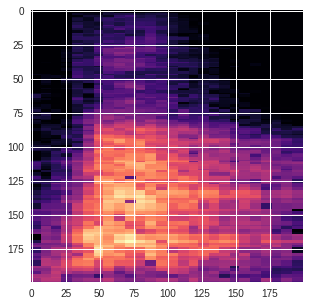

In [16]:
plt.figure(figsize=(8,5))
plt.imshow(x_train[256]/255)
plt.show()

In [14]:
with open('./api_cnn_tensor','wb') as f:
    pickle.dump(api_cnn_tensor,f, protocol=4)